**TITLE**: Reinforcement Learning for Stock Market (development)   
**AUTHOR**: Pablo Carrera Flórez de Quiñones  
**DATE**: Septembre 2020  

# INTRODUCTION

## Objectives

## Libraries

In [1]:
# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Basics
import numpy as np
import pandas as pd
import random
import logging
import time

# Punctual
from datetime import datetime
from collections import defaultdict, deque
import pandas_datareader as pdr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

# Reinforcement Learning
import gym
from gym import spaces

## Logging

In [2]:
# Create the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

##### Stream logging
# Set the format
formatter_stream = logging.Formatter('%(asctime)s : %(levelname)s %(message)s')

# Create a handler for showing the logs
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
stream_handler.setFormatter(formatter_stream)

# Add the handlers to the logger
logger.addHandler(stream_handler)
#####
    
##### File logging
# Set the format
formatter_file = logging.Formatter('%(asctime)s %(name)s %(lineno)d:%(levelname)s %(message)s')

# Create a handler for saving the logs
file_handler = logging.FileHandler('logging.log', mode = 'w')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter_file)

# Add the handlers to the logger
logger.addHandler(file_handler)
#####

# DATA

## Functions

In [3]:
def download_stock(stock, date_start = datetime(2010, 1, 1), date_end = datetime(2019, 12, 31), keep = 'Close'):
    '''
    Download historical prices from stocks of S&P500.
    
    Arguments:
        date_start (datetime): date to start tracking
        date_end (datetime): date to end tracking
        keep (string): columns to keep in the returned dataframe
    
    Returns:
        df_stocks (pd.DataFrame): time-series containing the historical prices of the stocks
    '''
    # Log
    logger.info('Start downloading data from {}'.format(stock))
    
    # Download and save data
    stock_list = [stock]
    for stock in stock_list:
        # The stocks listed now in S&P500 may not have data between the selected dates
        try:
            # Import data from Yahoo Finance
            df_stock = pdr.get_data_yahoo(symbols = [stock], start = date_start, end = date_end)
        
            # Delete annoying labels
            df_stock.columns = df_stock.columns.get_level_values(1)
            df_stock.columns.name = None
            df_stock.index.name = None

            # Rename columns
            df_stock.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

            # Reorder the columns
            df_stock = df_stock[['Open', 'Low', 'Close', 'High', 'Volume']]
        
            # Save values
            df_stock = df_stock[keep]
        except:
            # Log
            logger.debug('Error downloading data from {}'.format(stock))
            pass

    return df_stock

In [4]:
def download_stocks(date_start = datetime(2010, 1, 1), date_end = datetime(2019, 12, 31), keep = 'Close'):
    '''
    Download historical prices from stocks of S&P500.
    
    Arguments:
        date_start (datetime): date to start tracking
        date_end (datetime): date to end tracking
        keep (string): columns to keep in the returned dataframe
    
    Returns:
        df_stocks (pd.DataFrame): time-series containing the historical prices of the stocks
    '''
    # Log
    logger.info('Start downloading data from S&P500')
    
    # Get stocks form S&P500 from wikipedia (updated consistenly)
    tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    stock_list = tables[0].Symbol.values.tolist()
    stock_list = [s.replace('.', '-') for s in stock_list]
    
    # Download and save data for each stock
    df_stocks = {}
    for stock in stock_list:
        # The stocks listed now in S&P500 may not have data between the selected dates
        try:
            # Import data from Yahoo Finance
            df_stock = pdr.get_data_yahoo(symbols = [stock], start = date_start, end = date_end)
        
            # Delete annoying labels
            df_stock.columns = df_stock.columns.get_level_values(1)
            df_stock.columns.name = None
            df_stock.index.name = None

            # Rename columns
            df_stock.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

            # Reorder the columns
            df_stock = df_stock[['Open', 'Low', 'Close', 'High', 'Volume']]
        
            # Save values
            df_stocks[stock] = df_stock[keep]
        except:
            # Log
            logger.debug('Error downloading data from {}'.format(stock))
            pass
            
    # Log
    logger.info('End downloading data from S&P500')
    
    # Convert to a dataframe
    df_stocks = pd.DataFrame(df_stocks, columns = stock_list)

    return df_stocks

In [5]:
def plot_stocks(df_stocks, nrows = 5, ncols = 5, seed = 0):
    '''
    Compute and plot the cummulative returns of one stock's price time-series.

    Arguments:
        df_stocks (pd.DataFrame): time-series containing the historical prices of the stocks
        nrows (int): number of rows to plot
        ncols (int): number of cols to plot
        seed (int): seed for reproducibility

    Returns:
        fig (plt.figure): figure object containing the plots
    '''
    # Set seed
    np.random.seed(seed)
    
    # Select data for plotting
    stock_list = np.random.choice(df_stocks.columns, nrows * ncols, replace = False)
    
    # Prepare data for plotting
    df = df_stocks.rename_axis('Date').reset_index()
    
    # Create figure
    fig, axs = plt.subplots(figsize = (20, 2 * ncols), nrows = nrows, ncols = ncols, sharex = True)

    # Loop over stocks
    for i,ax in enumerate(axs.flat):
        # Make the plot
        sns.lineplot(x = 'Date', y = stock_list[i], data = df, ax = ax)
                
        # Formatting
        ax.set_title('{} - Daily'.format(stock_list[i]), weight = 'bold')
        ax.set_xlabel('')
        ax.set_ylabel('Price per share')
        ax.xaxis.set_tick_params(rotation = 45)
            
    # Formatting
    fig.tight_layout()

    return fig

In [6]:
def run_episodes_comparison(agent, stocks, date_start, date_end, time_horizon, time_skip):
    '''
    Compute and plot the cummulative returns of many stock's price time-series.

    Arguments:
        data   (pd.DataFrame): time-series containing the historical prices of the stocks
        stocks (string): tick of the stocks for the title of the plots
    '''
    
    

    
    # Run the episodes
    for i,stock in enumerate(stocks):
        # Get the results of the environment
        env = run_episode(agent,
                          stock        = stock, 
                          date_start   = date_start, 
                          date_end     = date_end, 
                          time_horizon = time_horizon, 
                          time_skip    = time_skip, 
                          show         = False
                          )
        
        # Update stats       
        df_stats = df_stats.append({'Stock'            : stock,
                                    'CummulativeReward' : env.df_stats['Reward'].sum(),
                                    'Balance'          : env.df_stats['Balance'].iloc[-1],
                                    }, ignore_index = True)
    
    # Create the plot
    plt.figure(figsize = (20, 5))
    
    # Plot comparison of Cummulative Rewards
    palette = np.array(sns.color_palette("Blues_d", len(stocks)))[df_stats['CummulativeReward'].argsort().argsort()]
    plt.subplot(1, 2, 1)
    sns.barplot(x = 'Stock', y = 'CummulativeReward', data = df_stats, palette = palette)
    plt.title('Comparison of Cummulative Rewards', weight = 'bold')
    plt.xlabel('')
    plt.ylabel('Cummulative reward')
    
    # Plot comparison of Balance
    palette = np.array(sns.color_palette("Blues_d", len(stocks)))[df_stats['CummulativeReward'].argsort().argsort()]
    plt.subplot(1, 2, 2)
    sns.barplot(x = 'Stock', y = 'Balance', data = df_stats, palette = palette)
    plt.title('Comparison of Balance', weight = 'bold')
    plt.xlabel('')
    plt.ylabel('Balance')
        
    # Formatting
    plt.tight_layout()
    plt.show()

## EDA

The first step is to obtain data from stock market. The majority of APIs that provide this data in real-time are private, but we can use the Yahoo! API in order to get the daily values of the stock's prices. We have developed the functions *download_stocks* to download the data of S&P500 

In [7]:
# Download data
data = download_stocks(date_start = datetime(2015, 1, 1), date_end = datetime(2019, 12, 31))

# Show
data.head()

2020-09-03 19:29:02,588 : INFO Start downloading data from S&P500
2020-09-03 19:30:00,302 : DEBUG Error downloading data from BR
2020-09-03 19:30:13,421 : DEBUG Error downloading data from CBOE
2020-09-03 19:30:14,306 : DEBUG Error downloading data from CBRE
2020-09-03 19:30:15,254 : DEBUG Error downloading data from CDW
2020-09-03 19:30:17,198 : DEBUG Error downloading data from CNC
2020-09-03 19:30:27,260 : DEBUG Error downloading data from CB
2020-09-03 19:30:32,965 : DEBUG Error downloading data from CSCO
2020-09-03 19:30:38,397 : DEBUG Error downloading data from CME
2020-09-03 19:30:44,747 : DEBUG Error downloading data from CMA
2020-09-03 19:31:01,254 : DEBUG Error downloading data from CVS
2020-09-03 19:31:14,328 : DEBUG Error downloading data from DLR
2020-09-03 19:31:20,625 : DEBUG Error downloading data from DG
2020-09-03 19:31:45,118 : DEBUG Error downloading data from EOG
2020-09-03 19:31:47,325 : DEBUG Error downloading data from EQIX
2020-09-03 19:31:51,852 : DEBUG Error

MMM        ABT       ABBV       ABMD        ACN       ATVI  \
2015-01-02  164.059998  44.900002  65.889999  37.310001  88.839996  20.129999   
2015-01-05  160.360001  44.910000  64.650002  37.070000  87.339996  19.850000   
2015-01-06  158.649994  44.400002  64.330002  36.130001  86.709999  19.480000   
2015-01-07  159.800003  44.759998  66.930000  37.279999  88.529999  19.059999   
2015-01-08  163.630005  45.680000  67.629997  38.959999  89.879997  19.250000   

                 ADBE   AMD         AAP    AES  ...  WYNN        XEL  XRX  \
2015-01-02  72.339996  2.67  158.559998  13.70  ...   NaN  36.119999  NaN   
2015-01-05  71.980003  2.66  156.470001  13.31  ...   NaN  35.709999  NaN   
2015-01-06  70.529999  2.63  156.360001  13.01  ...   NaN  35.900002  NaN   
2015-01-07  71.110001  2.58  159.720001  13.03  ...   NaN  36.209999  NaN   
2015-01-08  72.919998  2.61  161.119995  13.23  ...   NaN  36.630001  NaN   

                 XLNX        XYL        YUM       ZBRA         ZBH       ZION  \
2015-01-02  43.599998  38.080002  52.012939  77.430000  112.589996  28.290001   
2015-01-05  42.799999  35.709999  50.956146  76.339996  116.790001  27.230000   
2015-01-06  42.180000  35.500000  50.330696  75.790001  115.800003  26.190001   
2015-01-07  42.200001  35.779999  51.998562  77.720001  118.680000  26.440001   
2015-01-08  43.139999  36.049999  52.904385  79.379997  119.940002  26.809999   

                  ZTS  
2015-01-02  43.310001  
2015-01-05  43.049999  
2015-01-06  42.630001  
2015-01-07  43.509998  
2015-01-08  44.180000  

[5 rows x 505 columns]

and the function *plot_stocks* to inspect the data visually

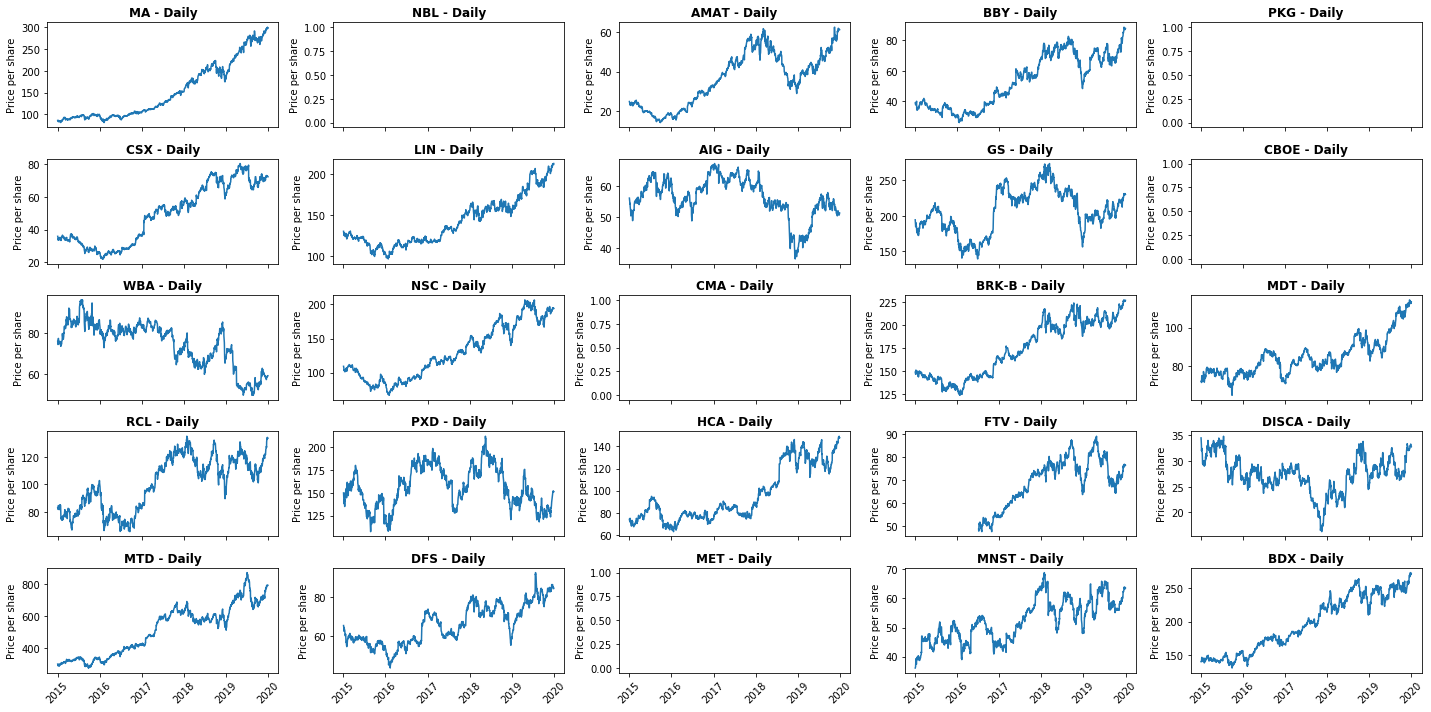

In [8]:
# Plot data
fig = plot_stocks(data, nrows = 5, ncols = 5, seed = 1)
fig.show()

# DEFINITION OF ENVIRONMENTS

As we said an environment comprise everything outside the agent, so its code implementation has to contain all the functionality to allow the agent to interact with it and to learn. We are going to implement this environment according to the guidelines of OpenAI gym \[1\], one on the most used libraries to develop reinforcement learning applications. The environments are then defined as a class with the following methods:
* __init(self)__: define initial information of the environment such as the observation space or the action space.
* __reset(self)__: reset the environment's state.
* __step(self, action)__: step the environment by one timestep. Returns
    * _observation_ (object): an environment-specific object representing our observation of the environment. 
    * _reward_ (float): amount of reward achieved by the previous action.
    * _done_ (boolean): whether it’s time to reset the environment again.
    * _info_ (dict): diagnostic information useful for debugging. 
* __render(self, mode='human')__: render one frame of the environment.  

## One stock

In order to build an agent to operate in Stock Market, first we have to define how the agent should perceive its environment, that is, we have to build a simulator for the Stock Market. In this sense, we need to consider how a human will perform the task. To formulate RL problem, we need to define three things: 
* **Observations**: at any time-step we have available the time-series of prices for a stock at any previous time-step, so we are defining each state as a the previous *time_horizon* prices. The other information that a human has is its current positions regarding this stock, that is, flat, long or short, so we are using this information also as a part of the state.
* **Actions**: there are three posible actions at any time-step regarding a stock: hold, buy or sell. So we are going to implement they as follow: 
    * Hold: do nothing, that is, skip the time-step without taking actions.  
    * Buy: open a position, that is, buy a share and save the *entry_price* at this time to compute the profit.  
    * Sell: close a position, that is, sell a share and save the price at this time to compute the *entry_price*.  
* **Positions**: however only some combinations of actions and positions are possible. We are going to implement the logic of positions and actions as follows:
   * *Flat*: you can hold to stay Flat (0), pass buy to become Long (1) or sell to become Short(2).
   * *Long*: you can hold to stay Long (0) or sell to become Flat(2). Buy to become Long (1) will be considered as hold to stay Long(0).
   * *Short*: you can hold to stay Short (0) or buy to become Flat(1). Sell to become Short (2) will be considered as hold to stay Short(0).
* **Rewards**: the usual way to analyze the evolution of prices in Stock Market and build profitable portfolios is not by directly analyzing the prices itself, but the so-called returns. Returns denote the relative change of the price in each time-step, which is a is more robust approach that using the prices themselves because its normalization, which allow to generalize better between different stocks. Due to the casuistry of each positions, rewards are computed in different ways depending on the position taken by the agent:
    * *Flat*: if the agent has no position opened, the reward at time-step $t$ is:
$$ R_t = 0 $$
    * *Long*: if the agent buys at time-step $t_{entry}$ at price $P_{entry}$, the reward at time-step $t$ is: 
$$ R_t =  \frac{P_{t} - P_{entry}}{P_{entry}} $$
    * *Short*: if the agent sells at time-step $t_{entry}$ at price $P_{entry}$, the reward at time-step $t$ is: 
$$ R_t =  \frac{P_{entry} - P_{t}}{P_{entry}} $$
* **Fees**: in out simulator of the environment, we reproduce the brokerage fee, which is the fee that is charged when we buy or sell stocks. The introduction of a fee also incentivize profit that is sustained over time, generating long-term strategies that gain money consistently rather that rapidly gain money using unsustainable strategies. This can be implemented as a fixed amount, as a percentage of the operations or as a combination of both ones. We choose to implement it as a fixed percentage of the operation, so taking it into account, the rewards after closing a positions are computed as:
    * *Long*: if the agent buys at time-step $t_{entry}$ at price $P_{entry}$, and sells at time-step $t_{exit}$ at price $P_{exit}$, the reward at time-step $t_{exit}$ is: 
$$ R_f = \left(1 + \frac{P_{exit} - P_{entry}}{P_{entry}} \right) (1 - \epsilon) - 1 $$
    * *Short*: if the agent sells at time-step $t_{entry}$ at price $P_{entry}$, and buy at time-step $t_{exit}$ at price $P_{exit}$, the reward at time-step $t_{exit}$ is: 
$$ R_f = \left(1 + \frac{P_{entry} - P_{exit}}{P_{entry}} \right) (1 - \epsilon) - 1 $$

In [7]:
class OneStockEnv(gym.Env):
    '''
    Reinforcement Leaning environment representing a Stock Market with a single stock.
    
    Actions:
        * 0 : Hold
        * 1 : Buy
        * 2 : Sell
    
    Positions:
        * 0 : Flat
        * 1 : Long
        * 2 : Short
    '''
    def __init__(self,
                 stock        = None, 
                 date_start   = datetime(2010, 1, 1),
                 date_end     = datetime(2019, 12, 31),
                 time_horizon = 10, 
                 time_skip    = 1,
                 balance      = 1.0,
                 fee          = 0.01
                 ):
        '''
        Initialization of the environment.
        
        Arguments:
            stock (string): tick of the stock to download
            date_start (datetime): date to start tracking
            date_end (datetime): date to end tracking
            time_horizon (int): number of timesteps inside each state
            time_skip (int): number of timesteps to skip between states
            balance (float): balance of the account
            fee (float): transaction fee as a percentage of the operation
        '''
        # Log
        logger.info('Creating environment')
        
        # Get the data
        self.data       = download_stock(stock = stock, date_start = date_start, date_end = date_end)
        self.stock      = stock
        self.date_start = date_start
        self.date_end   = date_end
        
        # Set the hyparameters of the environment
        self.time_horizon = time_horizon
        self.time_skip    = time_skip
        self.balance      = balance
        self.fee          = fee 
        
        # Save useful values
        self.n_features  = 1
        self.n_actions   = 3
        self.n_positions = 3

        # Initialize the environment
        self.reset()
    
    def reset(self):
        '''
        Initalize temporal variables.
        '''            
        # Intialize the values
        self.n_timesteps = (self.data.shape[0] - self.time_horizon) // self.time_skip
        self.t = self.time_horizon
        self.position = 0
        self.done = False

        # Initialize a dataframe to save stats      
        self.df_stats = pd.DataFrame(columns = ['Date',
                                                'Price',
                                                'Position',
                                                'Action',
                                                'Reward',
                                                'Balance'
                                                ]).astype({'Price'    : 'float32',
                                                           'Position' : 'int32', 
                                                           'Action'   : 'int32', 
                                                           'Reward'   : 'float32',
                                                           'Balance'  : 'float32'
                                                           })
        
        # Get first state
        initial_state = self._prepare_state()
        
        return initial_state
    
    def _prepare_state(self):
        '''
        Prepare the state for the agent joining the price infomation and the actual position
        '''

        # Get time-series of prices
        state_price = self.data.iloc[(self.t - self.time_horizon):self.t]
        state_price = np.array(state_price).reshape(1,self.time_horizon,self.n_features)
        
        # Get position
        state_position = np.zeros((1, self.n_positions, self.n_features))
        state_position[0, self.position, 0] = 1
        
        # Join
        state = [state_price, state_position]
        
        return state

    def step(self, action):
        '''
        Advance a timestep in the environment.
        '''
        # FLAT
        if self.position == 0:
            # Hold
            if action == 0:
                reward = 0
            # Buy
            elif action == 1:
                reward = 0
                
                # Update position to LONG
                self.position = 1
                
                # Save entry price
                self.entry_price = self.data[self.t]
            # Sell
            else:
                reward = 0
                
                # Update position to SHORT
                self.position = 2
                
                # Save entry price
                self.entry_price = self.data[self.t]
        
        # LONG
        elif self.position == 1:
            # Hold
            if action == 0:
                reward = (self.data[self.t] - self.entry_price)/self.entry_price
            # Buy
            elif action == 1:
                # Equivalent to hold
                action = 0
                
                # Penalize this action
                reward = -1
            # Sell
            else:
                # Update position to FLAT
                self.position = 0
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect exit_price > entry_price)
                reward = ( 1 + (self.exit_price - self.entry_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)
                
        # SHORT
        else:
            # Hold
            if action == 0:
                reward = (self.entry_price - self.data[self.t])/self.entry_price
            # Buy
            elif action == 1:
                # Update position to FLAT
                self.position = 0
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect entry_price > exit_price)
                reward = ( 1 + (self.entry_price - self.exit_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)                    
            # Sell
            else:
                # Equivalent to hold
                action = 0
                
                # Penalize this action
                reward =-1
                
        # Update stats       
        self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                              'Price'    : self.data[self.t],
                                              'Position' : self.position,
                                              'Action'   : action, 
                                              'Reward'   : reward,
                                              'Balance'  : self.balance
                                              }, ignore_index = True)

        # Prepare the next step
        self.t += self.time_skip
        next_state = self._prepare_state()
        
        # Check if next state is terminal
        if (self.t + self.time_skip) >= len(self.data):
            # End the episode
            self.done = True
        
            # Close the opened positions
            # LONG
            if self.position == 1:
                # Sell
                action = 2
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect exit_price > entry_price)
                reward = ( 1 + (self.exit_price - self.entry_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)
                
                # Update stats       
                self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                                      'Price'    : self.data[self.t],
                                                      'Position' : self.position,
                                                      'Action'   : action, 
                                                      'Reward'   : reward,
                                                      'Balance'  : self.balance
                                                      }, ignore_index = True)
            
            # SHORT
            elif self.position == 2:
                # Buy
                action = 1
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect entry_price > exit_price)
                reward = ( 1 + (self.entry_price - self.exit_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1) 
            
                # Update stats       
                self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                                      'Price'    : self.data[self.t],
                                                      'Position' : self.position,
                                                      'Action'   : action, 
                                                      'Reward'   : reward,
                                                      'Balance'  : self.balance
                                                      }, ignore_index = True)

        # Return (obs, reward, done, info)
        return (next_state, reward, self.done, {})

    def render(self, mode = 'human', verbose = False):
        pass

## One random stock

In [8]:
class OneRandomStockEnv(gym.Env):
    '''
    Reinforcement Leaning environment representing a Stock Market with a single stock.
    
    Actions:
        * 0 : Hold
        * 1 : Buy
        * 2 : Sell
    
    Positions:
        * 0 : Flat
        * 1 : Long
        * 2 : Short
    '''
    def __init__(self,
                 stock        = None, 
                 date_start   = datetime(2010, 1, 1),
                 date_end     = datetime(2019, 12, 31),
                 time_horizon = 10, 
                 time_skip    = 1,
                 balance      = 1.0,
                 fee          = 0.01
                 ):
        '''
        Initialization of the environment.
        
        Arguments:
            stock (string): tick of the stock to download
            date_start (datetime): date to start tracking
            date_end (datetime): date to end tracking
            time_horizon (int): number of timesteps inside each state
            time_skip (int): number of timesteps to skip between states
            balance (float): balance of the account
            fee (float): transaction fee as a percentage of the operation
        '''
        # Log
        logger.info('Creating environment')
        
        # Get the data
        self.data_raw   = download_stocks(date_start = date_start, date_end = date_end)
        self.data_raw   = self.data_raw.dropna(axis = 1, thresh = time_horizon + time_skip)
        self.stock_raw  = stock
        self.date_start = date_start
        self.date_end   = date_end
        
        # Set the hyparameters of the environment
        self.time_horizon = time_horizon
        self.time_skip    = time_skip
        self.balance      = balance
        self.fee          = fee 
        
        # Save useful values
        self.n_features  = 1
        self.n_actions   = 3
        self.n_positions = 3

        # Initialize the environment
        self.reset()
    
    def reset(self, stock_new = None):
        '''
        Initalize temporal variables.
        '''
        # Initialize the time series
        if self.stock_raw:
            # Keep
            self.stock = self.stock_raw
            
            # Download selected stock
            self.data = self.data_raw[self.stock]
        else:
            if stock_new:
                # Download selected stock
                self.data = self.data_raw[stock_new]
                self.balance = 1.0
            else:
                # Select randomly
                self.stock = np.random.choice(self.data_raw.columns, 1)[0]
                    
                # Download selected stock
                self.data = self.data_raw[self.stock]
            
        # Intialize the values
        self.n_timesteps = (self.data.shape[0] - self.time_horizon) // self.time_skip
        self.t = self.time_horizon
        self.position = 0
        self.done = False

        # Initialize a dataframe to save stats      
        self.df_stats = pd.DataFrame(columns = ['Date',
                                                'Price',
                                                'Position',
                                                'Action',
                                                'Reward',
                                                'Balance'
                                                ]).astype({'Price'    : 'float32',
                                                           'Position' : 'int32', 
                                                           'Action'   : 'int32', 
                                                           'Reward'   : 'float32',
                                                           'Balance'  : 'float32'
                                                           })
        
        # Get first state
        initial_state = self._prepare_state()
        
        return initial_state
    
    def _prepare_state(self):
        '''
        Prepare the state for the agent joining the price infomation and the actual position
        '''

        # Get time-series of prices
        state_price = self.data.iloc[(self.t - self.time_horizon):self.t]
        state_price = np.array(state_price).reshape(1,self.time_horizon,self.n_features)
        
        # Get position
        state_position = np.zeros((1, self.n_positions, self.n_features))
        state_position[0, self.position, 0] = 1
        
        # Join
        state = [state_price, state_position]
        
        return state

    def step(self, action):
        '''
        Advance a timestep in the environment.
        '''
        # FLAT
        if self.position == 0:
            # Hold
            if action == 0:
                reward = 0
            # Buy
            elif action == 1:
                reward = 0
                
                # Update position to LONG
                self.position = 1
                
                # Save entry price
                self.entry_price = self.data[self.t]
            # Sell
            else:
                reward = 0
                
                # Update position to SHORT
                self.position = 2
                
                # Save entry price
                self.entry_price = self.data[self.t]
        
        # LONG
        elif self.position == 1:
            # Hold
            if action == 0:
                reward = (self.data[self.t] - self.entry_price)/self.entry_price
            # Buy
            elif action == 1:
                # Equivalent to hold
                action = 0
                reward = (self.data[self.t] - self.entry_price)/self.entry_price
            # Sell
            else:
                # Update position to FLAT
                self.position = 0
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect exit_price > entry_price)
                reward = ( 1 + (self.exit_price - self.entry_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)
                
        # SHORT
        else:
            # Hold
            if action == 0:
                reward = (self.entry_price - self.data[self.t])/self.entry_price
            # Buy
            elif action == 1:
                # Update position to FLAT
                self.position = 0
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect entry_price > exit_price)
                reward = ( 1 + (self.entry_price - self.exit_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)                    
            # Sell
            else:
                # Equivalent to hold
                action = 0
                reward = (self.entry_price - self.data[self.t])/self.entry_price
                
        # Update stats       
        self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                              'Price'    : self.data[self.t],
                                              'Position' : self.position,
                                              'Action'   : action, 
                                              'Reward'   : reward,
                                              'Balance'  : self.balance
                                              }, ignore_index = True)

        # Prepare the next step
        self.t += self.time_skip
        next_state = self._prepare_state()
        
        # Check if next state is terminal
        if (self.t + self.time_skip) >= len(self.data):
            # End the episode
            self.done = True
        
            # Close the opened positions
            # LONG
            if self.position == 1:
                # Sell
                action = 2
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect exit_price > entry_price)
                reward = ( 1 + (self.exit_price - self.entry_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1)
                
                # Update stats       
                self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                                      'Price'    : self.data[self.t],
                                                      'Position' : self.position,
                                                      'Action'   : action, 
                                                      'Reward'   : reward,
                                                      'Balance'  : self.balance
                                                      }, ignore_index = True)
            
            # SHORT
            elif self.position == 2:
                # Buy
                action = 1
                
                # Save exit price
                self.exit_price = self.data[self.t]
                
                # Compute reward (expect entry_price > exit_price)
                reward = ( 1 + (self.entry_price - self.exit_price)/self.entry_price ) * (1 - self.fee) - 1
                self.balance = self.balance * (reward + 1) 
            
                # Update stats       
                self.df_stats = self.df_stats.append({'Date'     : self.data.index[self.t],
                                                      'Price'    : self.data[self.t],
                                                      'Position' : self.position,
                                                      'Action'   : action, 
                                                      'Reward'   : reward,
                                                      'Balance'  : self.balance
                                                      }, ignore_index = True)

        # Return (obs, reward, done, info)
        return (next_state, reward, self.done, {})

    def render(self, mode = 'human', verbose = False):
        pass

## Possible improvements

* **Quantities**: we need to know the amount of a given stock to buy or sell each time. Using gym's Box space, we can create an *action_space* that has a discrete number of action types (hold, buy and sell), as well as a continuous spectrum of amounts to buy/sell (0-100% of the account balance/position size respectively). Note that the amount is not necessary for the hold action, but will be provided anyway, we expect the agent to learn that the amount is not relevant for this action.

#  DEFINITION OF ALGORITHMS

## Functions

In [9]:
def plot_training_stats(env, agent, rolling = 10):
    '''
    Plot the evolution of some variables during the training of the agent
        * Loss: value of the loss function for the current minibatch
        * Q-values of Q-network:
        * Q-values of target network:
    '''
    # Pepare dataframe
    df = agent.df_stats.rolling(rolling).mean()
    
    # Plot stats
    plt.figure(figsize = (20,5))
    
    # Plot evolution of loss
    plt.subplot(1,3,1)
    sns.lineplot(x = np.arange(len(df)), y = df['Loss'])
    plt.title('Evolution of loss', weight = 'bold')
    plt.xlabel('')
    plt.ylabel('Loss')
    
    # Plot evolution of Q-values
    plt.subplot(1,3,2)
    sns.lineplot(x = np.arange(len(df)), y = df['Q-hold'], label = 'Q-hold', color = 'blue')
    sns.lineplot(x = np.arange(len(df)), y = df['Q-buy '], label = 'Q-buy ', color = 'green')
    sns.lineplot(x = np.arange(len(df)), y = df['Q-sell'], label = 'Q-sell', color = 'red')
    plt.title('Evolution of Q-values', weight = 'bold')
    plt.xlabel('')
    plt.ylabel('Q-values')
    plt.legend()
    
    plt.subplot(1,3,3)
    sns.lineplot(x = np.arange(len(df)), y = df['Q-hold (target)'], label = 'Q-hold (target)', color = 'blue')
    sns.lineplot(x = np.arange(len(df)), y = df['Q-buy  (target)'], label = 'Q-buy  (target)', color = 'green')
    sns.lineplot(x = np.arange(len(df)), y = df['Q-sell (target)'], label = 'Q-sell (target)', color = 'red')
    plt.title('Evolution of Q-values', weight = 'bold')
    plt.xlabel('')
    plt.ylabel('Q-values')
    plt.legend()
    
    # Formating
    plt.tight_layout()

## Deep Q-learning (DQL) and beyond

In [10]:
class AgentDQN:
    def __init__(self, env, model,
                 epsilon         = 1.0,
                 epsilon_min     = 0.01,
                 epsilon_decay   = 0.995,
                 gamma           = 0.95,
                 batch_size      = 1,
                 memory_warmup   = 100,
                 memory_capacity = 1000
                 ):
        '''
        Initialize the hyperparameters of the learning process:
            epsilon         (float): parameter controlling the exploration
            epsilon_decay   (float): parameter controling the decay of the exploration parameter
            epsilon_min     (float): minimum value for the exploration parameter
            gamma           (float): discount factor for the return
            batch_size      (int):
            memory_warmup   (int): memory capacity to fill before starting experience replay
            memory_capacity (int): maximum memory capacity for experience replay
        '''
        # Log
        logger.info('Creating agent')
        
        # Environment
        self.env = env
        
        # Parameters for the self behavior
        self.epsilon       = epsilon
        self.epsilon_min   = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Pameters for the training
        self.gamma = gamma
        self.batch_size = batch_size
        
        # Memory for experience replay
        self.memory_warmup   = memory_warmup
        self.memory_capacity = memory_capacity
        
        self.memory = deque(maxlen = self.memory_capacity)
        
        # Model
        self.q_network        = model
        self.q_network_target = tf.keras.models.clone_model(model)
        self.q_network_target.set_weights(self.q_network.get_weights())
    
    def _store(self, state, action, reward, next_state, done_check):
        '''
        Store states in memory for experience replay.
        '''
        # Append the tuple to memory
        self.memory.append((state, action, reward, next_state, done_check))

    def _act(self, state):
        '''
        Take an action using a epsilon-greedy policy.
        '''
        # Exploration vs.exploitation
        if np.random.random() < self.epsilon:
            # Chose action at random
            action = np.random.choice(self.env.n_actions, 1)[0]
        else:
            # Get Q-values
            q_values = self.q_network.predict(state)[0]
            
            # Choose the best action
            action = np.argmax(q_values)
        
        # Decrease exploration
        self.epsilon = self.epsilon_decay * self.epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon)
        
        return action
    
    def train_deep_q_learning(self, num_episodes = 1):
        '''
        Implementatin of Deep Q-Learning algorithm: arXiv:1312.5602 [cs.LG].
        '''
        # Log
        logger.info('Training DQL')
        
        # Initialize a dataframe to save stats      
        self.df_stats = pd.DataFrame(columns = ['Loss',
                                                'Q-hold',
                                                'Q-buy ',
                                                'Q-sell',
                                                'Q-hold (target)',
                                                'Q-buy  (target)',
                                                'Q-sell (target)'
                                                ]).astype('float32')

        # Loop over episodes
        for episode in range(num_episodes):
            # Log
            if episode % 10 == 0:
                logger.debug('Running episode {}/{}'.format(episode, num_episodes))
    
            # Reset environment
            state = self.env.reset()
    
            # Get episode
            for step in range(self.env.n_timesteps):
                # Run Action
                action = self._act(state)  
                next_state, reward, done, info = self.env.step(action) 
        
                # Refresh memory
                self._store(state, action, reward, next_state, done)
            
                # Train
                if len(self.memory) > self.memory_warmup:
                    # Get minibatch from memory
                    minibatch = random.sample(self.memory, self.batch_size)
                    
                    for state_t, action_t, reward_t, state_t_next, done_check in minibatch:
                        # Compute prediction
                        y_t = self.q_network.predict(state_t)
            
                        # Apply update
                        if done_check:
                            y_t[0][action_t] = reward_t
                        else: 
                            y_t[0][action_t] = reward_t + self.gamma * np.max(self.q_network.predict(state_t_next))

                        # Perform gradient descent in minibatch
                        self.q_network.fit(state_t, y_t, epochs = 1, batch_size = self.batch_size, verbose = 0)
                    
                        # Update stats
                        self.df_stats = self.df_stats.append({'Loss'   : list(agent.q_network.history.history.values())[0][0],
                                                              'Q-hold' : self.q_network.predict(state)[0][0],
                                                              'Q-buy ' : self.q_network.predict(state)[0][1],
                                                              'Q-sell' : self.q_network.predict(state)[0][2],
                                                              'Q-hold (target)' : self.q_network_target.predict(state)[0][0],
                                                              'Q-buy  (target)' : self.q_network_target.predict(state)[0][1],
                                                              'Q-sell (target)' : self.q_network_target.predict(state)[0][2]
                                                              }, ignore_index = True)                    

                # Check if done and prepare next state if necesary 
                if done:
                    break
                else: 
                    state = next_state

    def train_deep_q_learning_with_target_network(self, num_episodes = 1, steps_to_align = 100):
        '''
        Implementatin of Deep Q-Learning algorithm: doi:10.1038/nature14236.
        '''
        # Log
        logger.info('Training DQL with target network')
        
        # Initialize a dataframe to save stats      
        self.df_stats = pd.DataFrame(columns = ['Loss',
                                                'Q-hold',
                                                'Q-buy ',
                                                'Q-sell',
                                                'Q-hold (target)',
                                                'Q-buy  (target)',
                                                'Q-sell (target)'
                                                ]).astype('float32')
        
        # Initialize variables
        align = 0

        # Loop over episodes
        for episode in range(num_episodes):
            # Log
            if episode % 10 == 0:
                logger.debug('Running episode {}/{}'.format(episode, num_episodes))
            
            # Reset environment
            state = self.env.reset()
    
            # Get episode
            for step in range(self.env.n_timesteps):
                # Run Action
                action = self._act(state)  
                next_state, reward, done, info = self.env.step(action) 
        
                # Refresh memory
                self._store(state, action, reward, next_state, done)
            
                # Train
                if len(self.memory) > self.memory_warmup:
                    # Get minibatch from memory
                    minibatch = random.sample(self.memory, self.batch_size)
                    
                    for state_t, action_t, reward_t, state_t_next, done_check in minibatch:
                        # Compute prediction
                        y_t = self.q_network.predict(state_t)
            
                        # Apply update
                        if done_check:
                            y_t[0][action_t] = reward_t
                        else: 
                            y_t[0][action_t] = reward_t + self.gamma * np.max(self.q_network_target.predict(state_t_next))
                    
                        # Perform gradient descent
                        self.q_network.fit(state_t, y_t, epochs = 1, batch_size = self.batch_size, verbose = 0)
                    
                        # Align if necessary
                        align += 1
                        if (align % steps_to_align) == 0:
                            self.q_network_target.set_weights(self.q_network.get_weights())
                        
                        # Update stats       
                        self.df_stats = self.df_stats.append({'Loss'   : list(agent.q_network.history.history.values())[0][0],
                                                              'Q-hold' : self.q_network.predict(state)[0][0],
                                                              'Q-buy ' : self.q_network.predict(state)[0][1],
                                                              'Q-sell' : self.q_network.predict(state)[0][2],
                                                              'Q-hold (target)' : self.q_network_target.predict(state)[0][0],
                                                              'Q-buy  (target)' : self.q_network_target.predict(state)[0][1],
                                                              'Q-sell (target)' : self.q_network_target.predict(state)[0][2]
                                                              }, ignore_index = True)                    

                    
                # Check if done and prepare next state if necesary 
                if done:                  
                    break
                else: 
                    state = next_state
                    
    def train_double_deep_q_learning(self, num_episodes = 1, steps_to_change = 100):
        '''
        Implementatin of Double Deep Q-Learning algorithm: arXiv:1509.06461 [cs.LG].
        '''
        # Log
        logger.info('Training DDQL')
        
        # Initialize a dataframe to save stats      
        self.df_stats = pd.DataFrame(columns = ['Loss',
                                                'Q-hold',
                                                'Q-buy ',
                                                'Q-sell',
                                                'Q-hold (target)',
                                                'Q-buy  (target)',
                                                'Q-sell (target)'
                                                ]).astype('float32')
        
        # Initialize variables
        change = 0

        # Loop over episodes
        for episode in range(num_episodes):
            # Log
            if episode % 10 == 0:
                logger.debug('Running episode {}/{}'.format(episode, num_episodes))
    
            # Reset environment
            state = self.env.reset()
    
            # Get episode
            for step in range(self.env.n_timesteps):
                # Run Action
                action = self._act(state)  
                next_state, reward, done, info = self.env.step(action) 
        
                # Refresh memory
                self._store(state, action, reward, next_state, done)
            
                # Train
                if len(self.memory) > self.memory_warmup:
                    # Get minibatch from memory
                    minibatch = random.sample(self.memory, self.batch_size)
                    
                    for state_t, action_t, reward_t, state_t_next, done_check in minibatch:
                        # Compute prediction
                        y_t = self.q_network.predict(state_t)
            
                        # Apply update
                        if done_check:
                            y_t[0][action_t] = reward_t
                        else:
                            action_pred = np.argmax(self.q_network.predict(state_t_next))
                            y_t[0][action_t] = reward_t + self.gamma * self.q_network_target.predict(state_t_next)[0][action_pred]

                        # Perform gradient descent in minibatch
                        self.q_network.fit(state_t, y_t, epochs = 1, batch_size = self.batch_size, verbose = 0)
                        
                        # Change networks if necessary
                        change += 1
                        if (change % steps_to_change) == 0:
                            # Create temporal network
                            temp = tf.keras.models.clone_model(self.q_network)
                            temp.set_weights(self.q_network.get_weights())
                            
                            # Change weights
                            self.q_network.set_weights(self.q_network_target.get_weights())
                            self.q_network_target.set_weights(temp.get_weights())
                        
                        # Update stats
                        self.df_stats = self.df_stats.append({'Loss'   : list(agent.q_network.history.history.values())[0][0],
                                                              'Q-hold' : self.q_network.predict(state)[0][0],
                                                              'Q-buy ' : self.q_network.predict(state)[0][1],
                                                              'Q-sell' : self.q_network.predict(state)[0][2],
                                                              'Q-hold (target)' : self.q_network_target.predict(state)[0][0],
                                                              'Q-buy  (target)' : self.q_network_target.predict(state)[0][1],
                                                              'Q-sell (target)' : self.q_network_target.predict(state)[0][2]
                                                              }, ignore_index = True)                    
              

                # Check if done and prepare next state if necesary 
                if done:
                    break
                else: 
                    state = next_state

# EXPERIMENTS

## Functions

In [11]:
def run_episode(env, agent):
    '''
    Given an agent and an environment run a episode.
    
    Arguments:
        env (gym.Env): environment simulating a Stock Market with one stock
        agent (AgentDQN): agent operating in a Stock Market with one stock
    '''
    # Initalize vars
    state = env.reset()
    done = False
    q_values = np.empty((env.n_features, env.n_actions))
    
    # Run the episode
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Save some values
        q_values = np.concatenate([q_values,probs], axis = 0)
        
        # Execute action
        state, reward, done, info = env.step(action)
        
    # Prepare dataframes
    df_q_values = pd.DataFrame(q_values, columns = ['Q-hold','Q-buy ','Q-sell'])
    
        
    # Create figure
    fig, axs = plt.subplots(figsize = (20, 3), nrows = 1, ncols = 4, sharex = True)
    
    # Plot actions
    sns.lineplot(x = 'Date', y = 'Price', data = env.df_stats, color = 'black', alpha = 0.5, ax = axs[0])
    axs[0].scatter(env.df_stats.loc[env.df_stats['Action'] == 1, 'Date'].values, env.df_stats.loc[env.df_stats['Action'] == 1, 'Price'].values, label = 'Buy', color = 'green', s = 100, marker = '^')
    axs[0].scatter(env.df_stats.loc[env.df_stats['Action'] == 2, 'Date'].values, env.df_stats.loc[env.df_stats['Action'] == 2, 'Price'].values, label = 'Sell', color = 'red', s = 100, marker = 'v')
    axs[0].set_title('{} - Daily'.format(env.stock), weight = 'bold')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Price per share')
    axs[0].xaxis.set_tick_params(rotation = 45)
    
    # Plot Q-values
    sns.lineplot(x = env.df_stats['Date'], y = df_q_values['Q-hold'], label = 'Q-hold', color = 'blue', ax = axs[1])
    sns.lineplot(x = env.df_stats['Date'], y = df_q_values['Q-buy '], label = 'Q-buy ', color = 'green', ax = axs[1])
    sns.lineplot(x = env.df_stats['Date'], y = df_q_values['Q-sell'], label = 'Q-sell', color = 'red', ax = axs[1])
    axs[1].set_title('Q-values', weight = 'bold')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Price per share')
    axs[1].xaxis.set_tick_params(rotation = 45)

    # Plot rewards
    sns.lineplot(x = env.df_stats['Date'], y = env.df_stats['Reward'].cumsum(), ax = axs[2])
    axs[2].set_title('Evolution of cummulative reward', weight = 'bold')
    axs[2].set_xlabel('')
    axs[2].set_ylabel('Cummulative reward')
    axs[2].xaxis.set_tick_params(rotation = 45)

    # Plot rewards
    sns.lineplot(x = env.df_stats['Date'], y = env.df_stats['Balance'], ax = axs[3])
    axs[3].set_title('Evolution of balance', weight = 'bold')
    axs[3].set_xlabel('')
    axs[3].set_ylabel('Balance')
    axs[3].xaxis.set_tick_params(rotation = 45)

    # Formating
    fig.tight_layout()
    
    return fig

In [12]:
def build_model_Dense(time_horizon, n_features, n_actions, hidden_size = 16, learning_rate = 0.01):
    # Log
    logger.info('Build Dense DQN')
        
    # Inputs
    input_prices   = Input(shape = (time_horizon, n_features), name = 'Prices')
    input_position = Input(shape = (3, n_features), name = 'Position')
    
    # Network for prices
    X_1 = Flatten(name = 'Flatten_prices')(input_prices)
    X_1 = Dense(hidden_size, activation = 'relu', name = 'Dense_1')(X_1)
    X_1 = Dense(hidden_size, activation = 'relu', name = 'Dense_2')(X_1)
    X_1 = Dense(hidden_size, activation = 'relu', name = 'Dense_3')(X_1)
    
    # Network for positions
    X_2 = Flatten(name = 'Flatten_positions')(input_position)
    
    # Concatenate networks
    X = Concatenate(name = 'Concatenate')([X_1,X_2])
    X = Dense(n_actions, activation = 'linear', name = 'Dense_Output')(X)
    
    # Create model
    model = Model([input_prices,input_position], X, name = 'Dense_DQN')
    
    # Compile model
    model.compile(loss = "mean_squared_error", optimizer = Adam(lr = learning_rate))
    
    # Show the model
    model.summary()
    time.sleep(1)

    return model

In [13]:
def build_model_LSTM(time_horizon, n_features, n_actions, hidden_size = 16, learning_rate = 0.01):
    # Log
    logger.info('Build LSTM DQN')
        
    # Inputs
    input_prices   = Input(shape = (time_horizon, n_features), name = 'Prices')
    input_position = Input(shape = (3, n_features), name = 'Position')
    
    # Network for prices
    X_1 = Bidirectional(LSTM(hidden_size, name = 'LSTM_1', return_sequences = True), name = 'Bidirectional_LSTM')(input_prices)
    X_1 = LSTM(hidden_size, name = 'LSTM_2')(X_1)
    
    # Network for positions
    X_2 = Flatten(name = 'Flatten_positions')(input_position)
    
    # Concatenate networks
    X = Concatenate(name = 'Concatenate')([X_1,X_2])
    X = Dense(n_actions, activation = 'linear', name = 'Dense_Output')(X)
    
    # Create model
    model = Model([input_prices,input_position], X, name = 'LSTM_DQN')
    
    # Compile model
    model.compile(loss = "mean_squared_error", optimizer = Adam(lr = learning_rate))
    
    # Show the model
    model.summary()
    time.sleep(1)

    return model

## Feedforward Neural Network

### DQL [1]

#### time\_horizon = 8

2020-07-19 16:55:37,065 : INFO Creating environment
2020-07-19 16:55:37,068 : INFO Start downloading data from AAPL
2020-07-19 16:55:37,885 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 8)            0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           288         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 16:55:39,366 : INFO Creating agent
2020-07-19 16:55:56,339 : INFO Training DQL
2020-07-19 16:55:56,348 : DEBUG Running episode 0/50
2020-07-19 16:59:18,875 : DEBUG Running episode 10/50
2020-07-19 17:02:21,402 : DEBUG Running episode 20/50
2020-07-19 17:05:30,372 : DEBUG Running episode 30/50
2020-07-19 17:08:34,215 : DEBUG Running episode 40/50


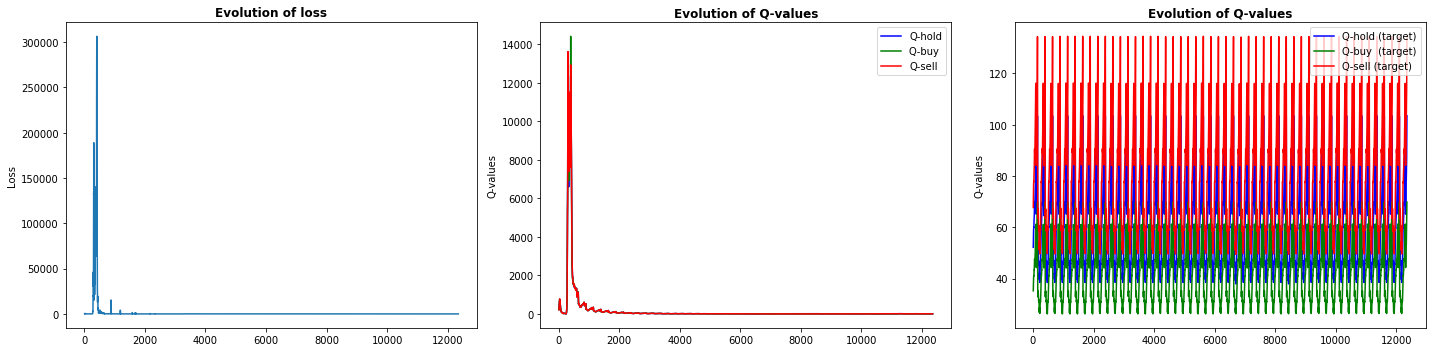

In [173]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_1_model_1.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 17:11:53,056 : INFO Creating environment
2020-07-19 17:11:53,057 : INFO Start downloading data from AAPL


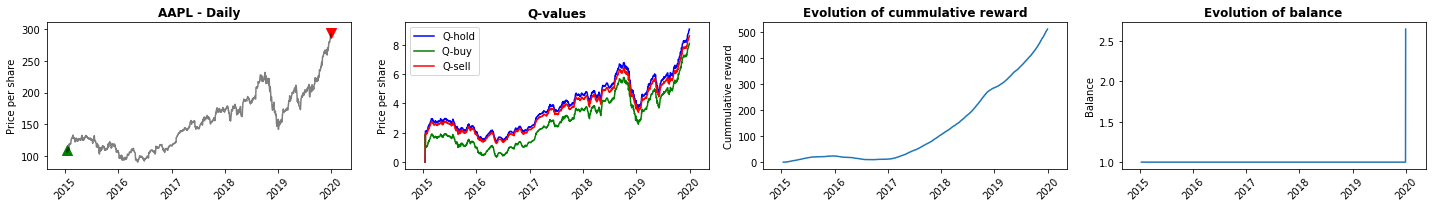

In [174]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_8_1.png')
    fig.show()

2020-07-19 17:12:14,078 : INFO Creating environment
2020-07-19 17:12:14,081 : INFO Start downloading data from GE


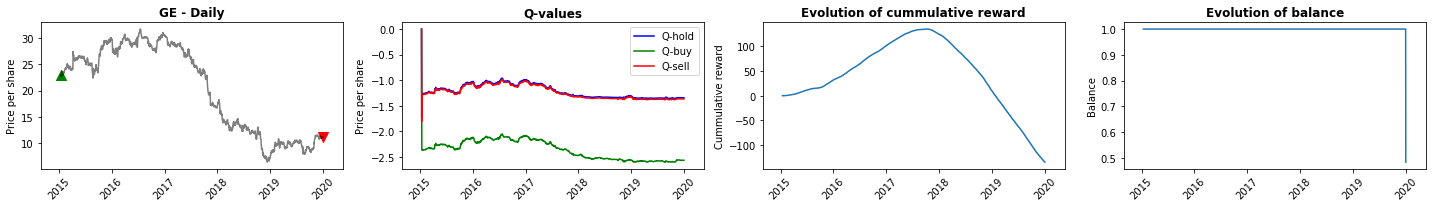

In [175]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_8_2.png')
    fig.show()

2020-07-19 17:12:35,356 : INFO Creating environment
2020-07-19 17:12:35,358 : INFO Start downloading data from CAT


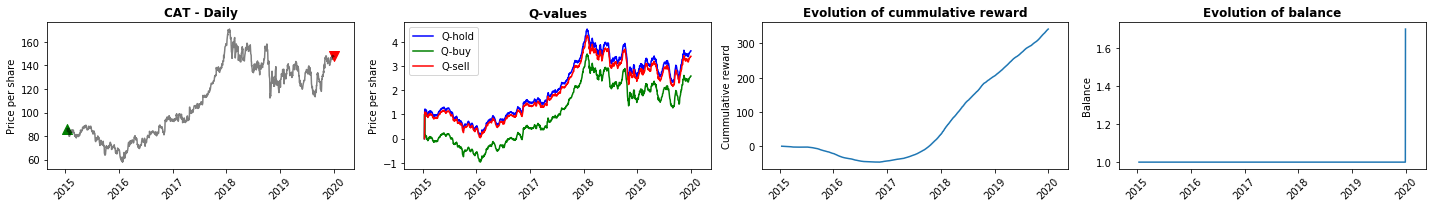

In [176]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-19 17:12:57,407 : INFO Creating environment
2020-07-19 17:12:57,409 : INFO Start downloading data from AAPL
2020-07-19 17:12:58,184 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 16)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           544         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 17:12:59,670 : INFO Creating agent
2020-07-19 17:13:16,079 : INFO Training DQL
2020-07-19 17:13:16,088 : DEBUG Running episode 0/50
2020-07-19 17:16:25,348 : DEBUG Running episode 10/50
2020-07-19 17:19:21,231 : DEBUG Running episode 20/50
2020-07-19 17:22:16,502 : DEBUG Running episode 30/50
2020-07-19 17:25:11,284 : DEBUG Running episode 40/50


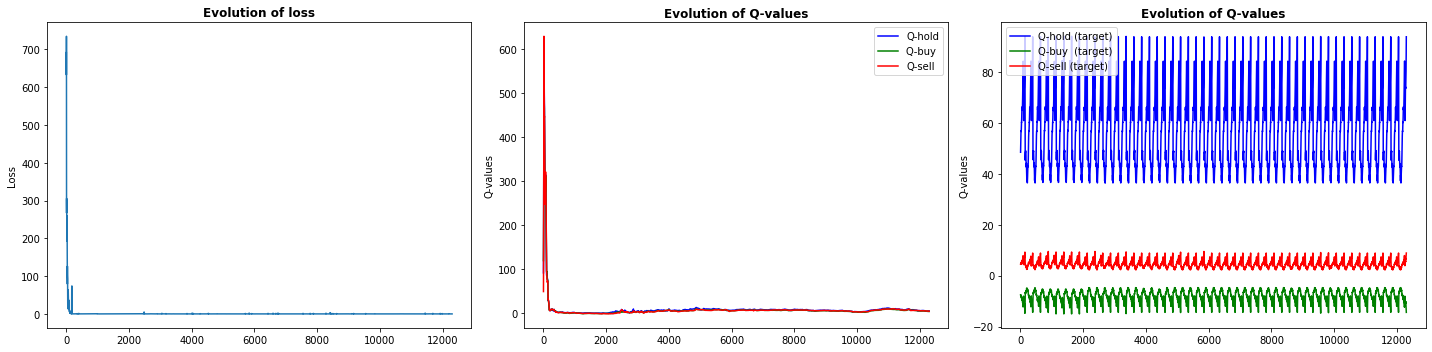

In [177]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_1_model_2.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 17:28:24,158 : INFO Creating environment
2020-07-19 17:28:24,160 : INFO Start downloading data from AAPL


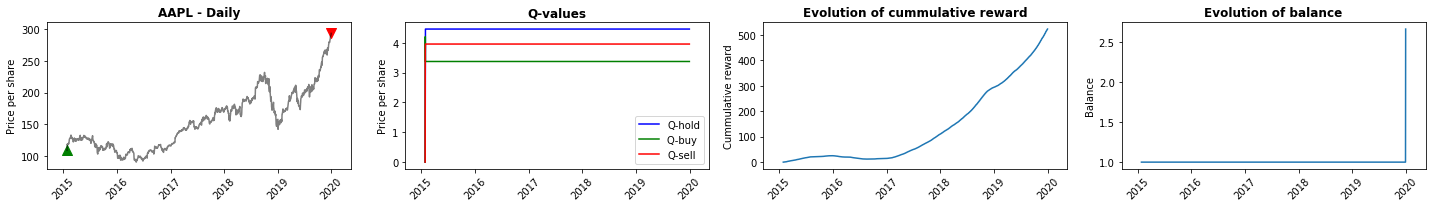

In [178]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_16_1.png')
    fig.show()

2020-07-19 17:28:44,605 : INFO Creating environment
2020-07-19 17:28:44,607 : INFO Start downloading data from GE


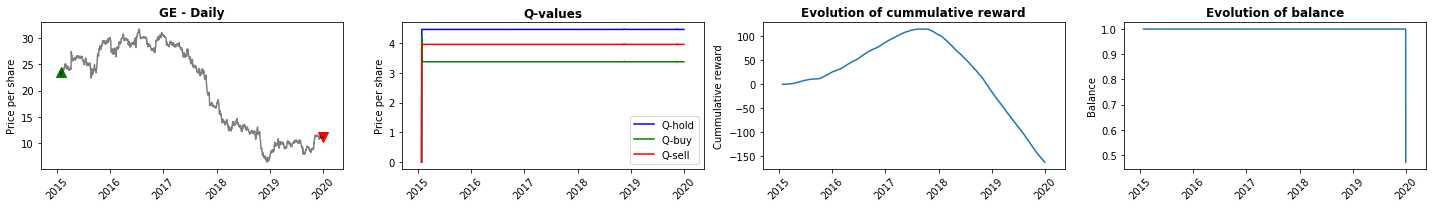

In [179]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_16_2.png')
    fig.show()

2020-07-19 17:29:05,536 : INFO Creating environment
2020-07-19 17:29:05,538 : INFO Start downloading data from CAT


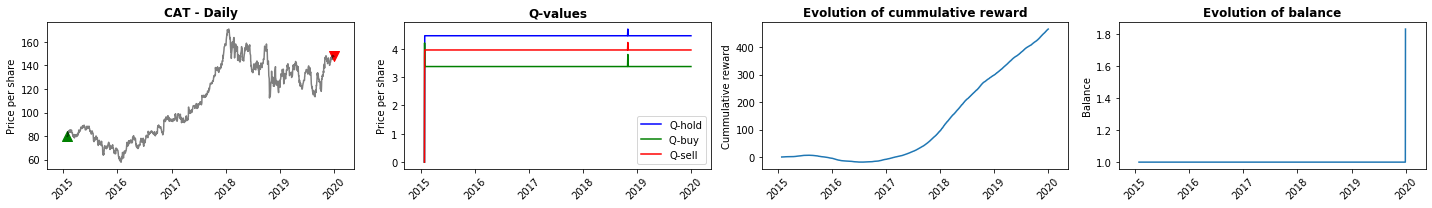

In [180]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-19 17:41:16,231 : INFO Creating environment
2020-07-19 17:41:16,232 : INFO Start downloading data from AAPL
2020-07-19 17:41:17,034 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 17:41:18,370 : INFO Creating agent
2020-07-19 17:41:29,649 : INFO Training DQL
2020-07-19 17:41:29,655 : DEBUG Running episode 0/50
2020-07-19 17:43:44,818 : DEBUG Running episode 10/50
2020-07-19 17:45:26,228 : DEBUG Running episode 20/50
2020-07-19 17:46:58,773 : DEBUG Running episode 30/50
2020-07-19 17:48:37,315 : DEBUG Running episode 40/50


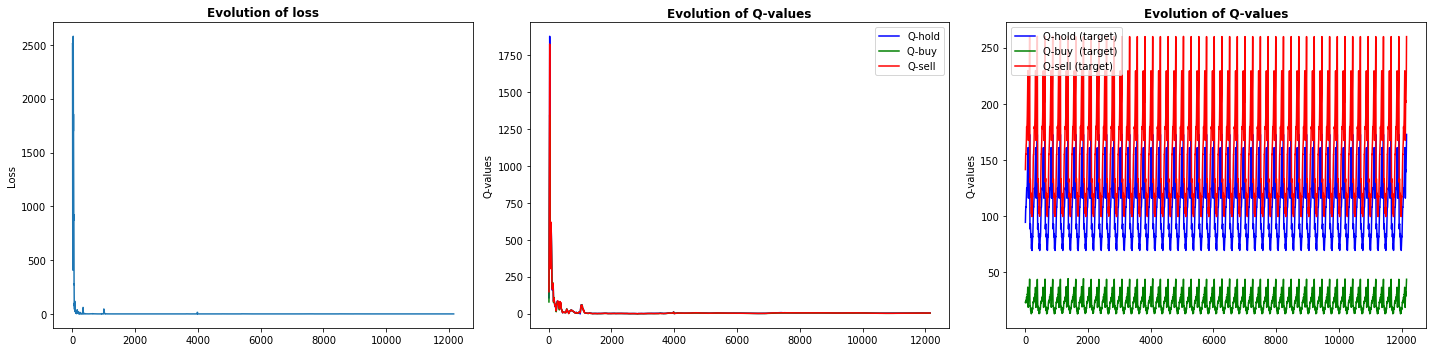

In [185]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_1_model_3.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 17:50:52,107 : INFO Creating environment
2020-07-19 17:50:52,108 : INFO Start downloading data from AAPL


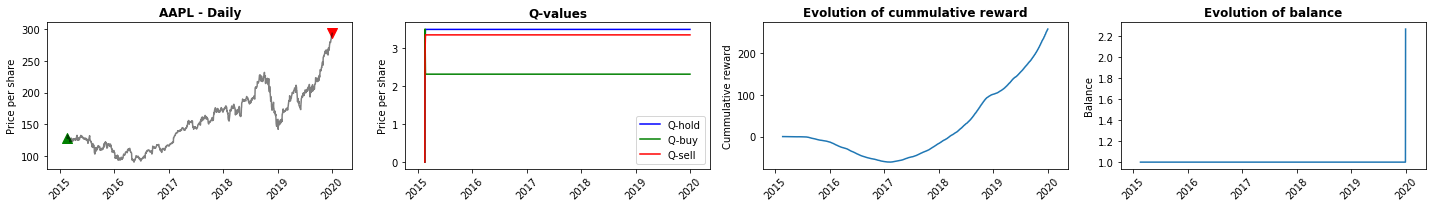

In [186]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_32_1.png')
    fig.show()

2020-07-19 17:51:05,147 : INFO Creating environment
2020-07-19 17:51:05,148 : INFO Start downloading data from GE


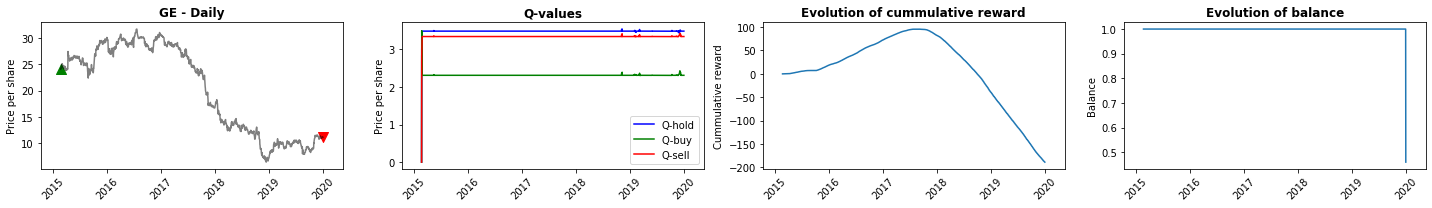

In [187]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_32_2.png')
    fig.show()

2020-07-19 17:51:18,231 : INFO Creating environment
2020-07-19 17:51:18,233 : INFO Start downloading data from CAT


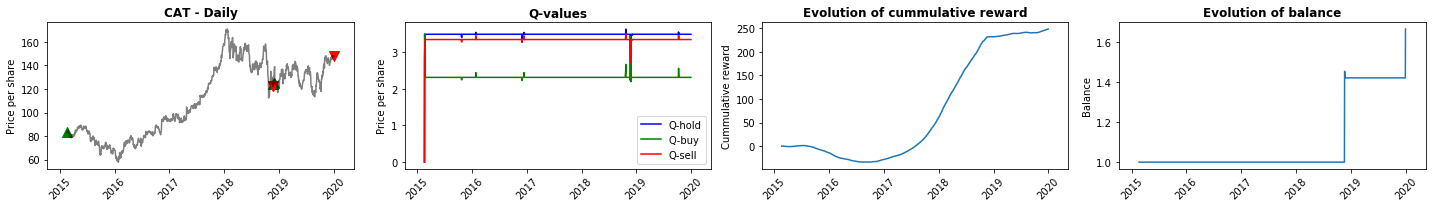

In [188]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_1_32_3.png')
    fig.show()

### DQL [2]

#### time\_horizon = 8

2020-07-19 17:51:50,512 : INFO Creating environment
2020-07-19 17:51:50,514 : INFO Start downloading data from AAPL
2020-07-19 17:51:51,529 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 8)            0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           288         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 17:51:52,646 : INFO Creating agent
2020-07-19 17:52:04,369 : INFO Training DQL with target network
2020-07-19 17:52:04,375 : DEBUG Running episode 0/50
2020-07-19 17:54:26,010 : DEBUG Running episode 10/50
2020-07-19 17:56:32,581 : DEBUG Running episode 20/50
2020-07-19 17:58:39,266 : DEBUG Running episode 30/50
2020-07-19 18:00:47,942 : DEBUG Running episode 40/50


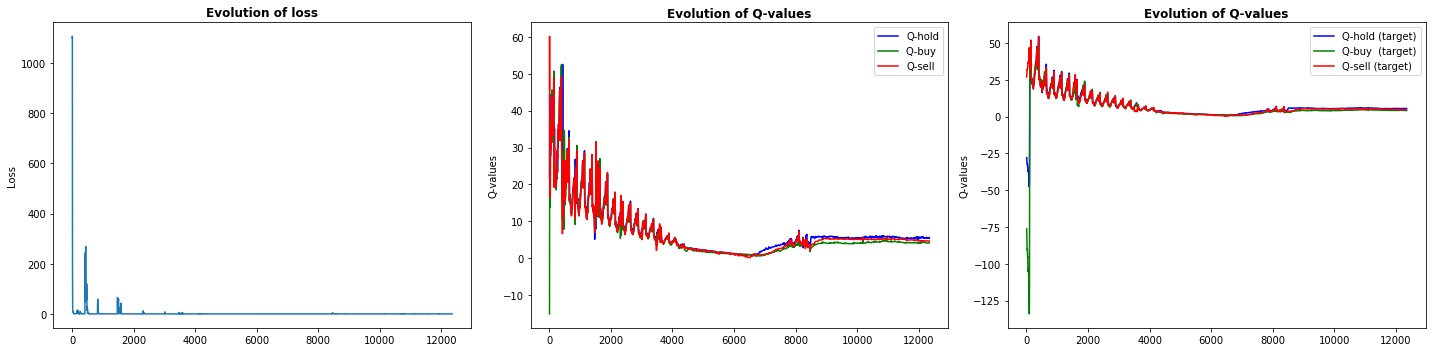

In [189]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 18:03:02,019 : INFO Creating environment
2020-07-19 18:03:02,019 : INFO Start downloading data from AAPL


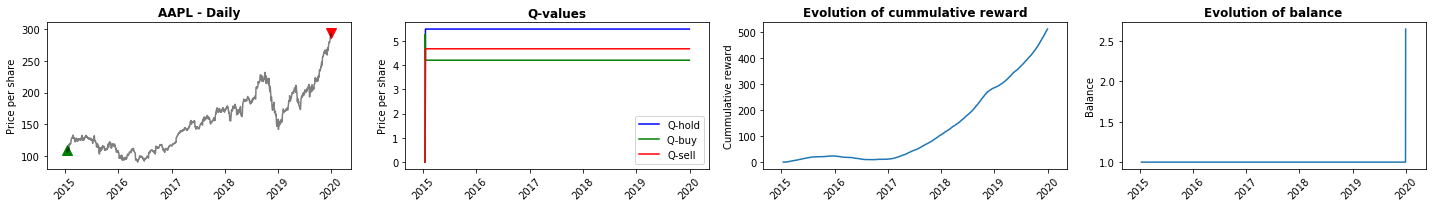

In [190]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )


# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_8_1.png')
    fig.show()

2020-07-19 18:03:15,912 : INFO Creating environment
2020-07-19 18:03:15,913 : INFO Start downloading data from GE


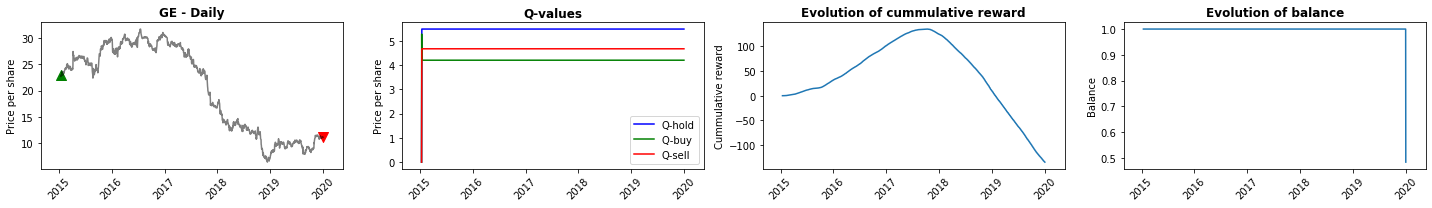

In [191]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )


# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_8_2.png')
    fig.show()

2020-07-19 18:03:30,501 : INFO Creating environment
2020-07-19 18:03:30,503 : INFO Start downloading data from CAT


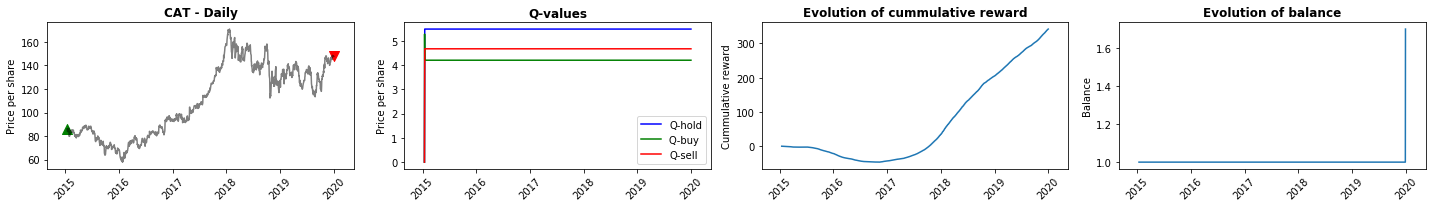

In [192]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )


# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-19 18:03:45,048 : INFO Creating environment
2020-07-19 18:03:45,049 : INFO Start downloading data from AAPL
2020-07-19 18:03:45,807 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 16)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           544         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 18:03:46,896 : INFO Creating agent
2020-07-19 18:03:58,555 : INFO Training DQL with target network
2020-07-19 18:03:58,561 : DEBUG Running episode 0/50
2020-07-19 18:06:15,822 : DEBUG Running episode 10/50
2020-07-19 18:08:24,600 : DEBUG Running episode 20/50
2020-07-19 18:10:34,616 : DEBUG Running episode 30/50
2020-07-19 18:12:49,382 : DEBUG Running episode 40/50


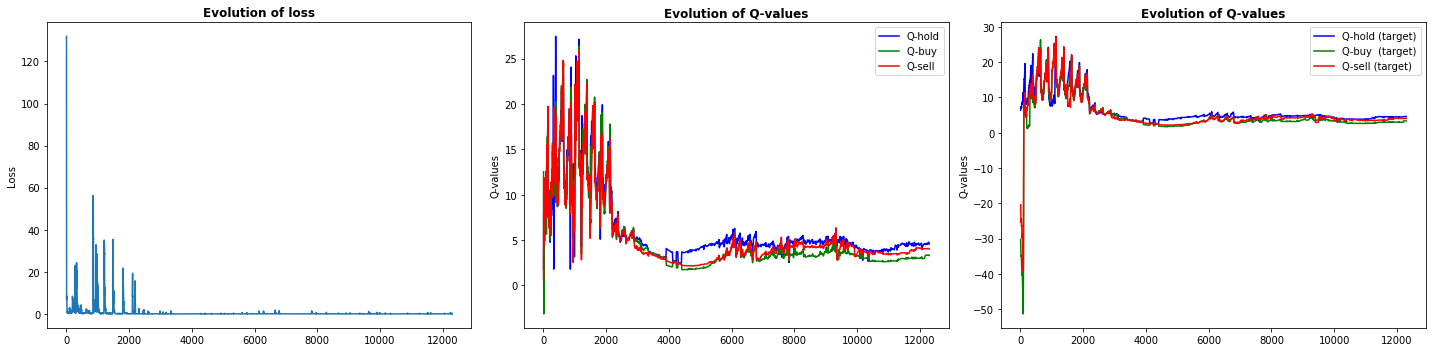

In [193]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 18:15:10,822 : INFO Creating environment
2020-07-19 18:15:10,823 : INFO Start downloading data from AAPL


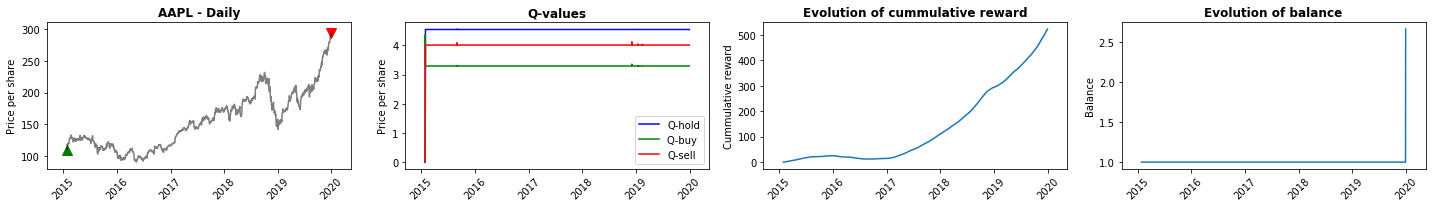

In [194]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_16_1.png')
    fig.show()

2020-07-19 18:15:24,691 : INFO Creating environment
2020-07-19 18:15:24,692 : INFO Start downloading data from GE


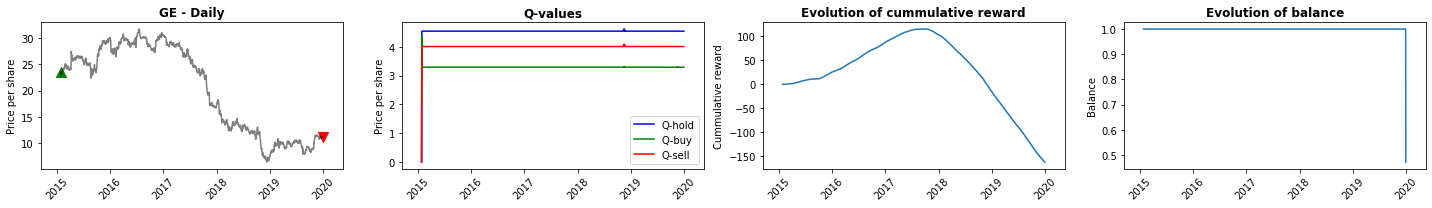

In [195]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_16_2.png')
    fig.show()

2020-07-19 18:15:40,101 : INFO Creating environment
2020-07-19 18:15:40,102 : INFO Start downloading data from CAT


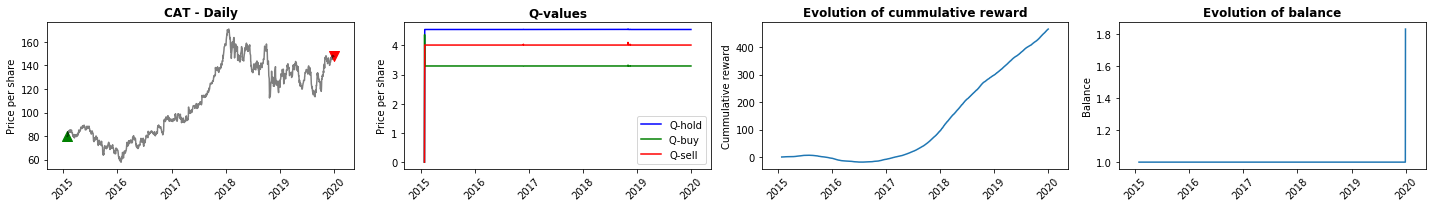

In [196]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-19 18:17:47,616 : INFO Creating environment
2020-07-19 18:17:47,617 : INFO Start downloading data from AAPL
2020-07-19 18:17:48,497 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 18:17:49,620 : INFO Creating agent
2020-07-19 18:18:01,829 : INFO Training DQL with target network
2020-07-19 18:18:01,834 : DEBUG Running episode 0/50
2020-07-19 18:20:23,202 : DEBUG Running episode 10/50
2020-07-19 18:22:36,639 : DEBUG Running episode 20/50
2020-07-19 18:24:49,644 : DEBUG Running episode 30/50
2020-07-19 18:26:42,515 : DEBUG Running episode 40/50


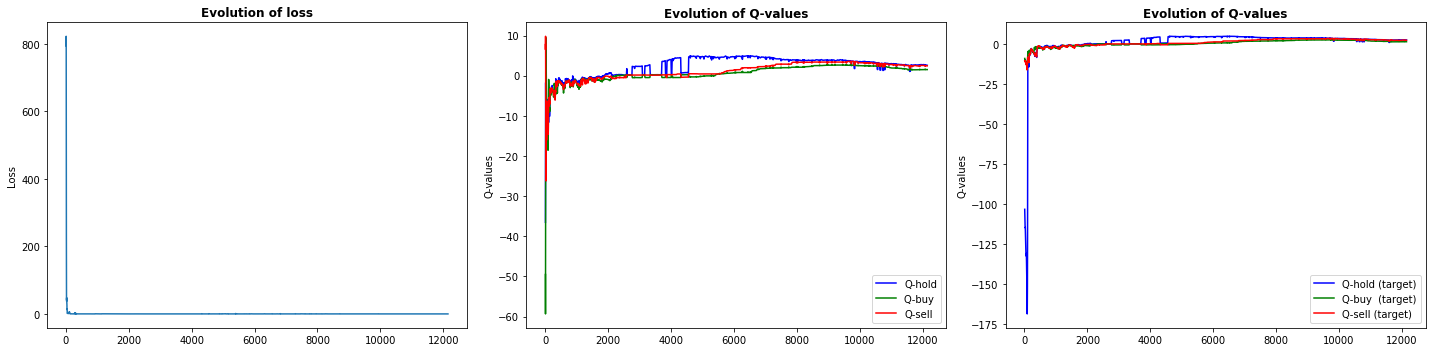

In [197]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 18:28:28,204 : INFO Creating environment
2020-07-19 18:28:28,205 : INFO Start downloading data from AAPL


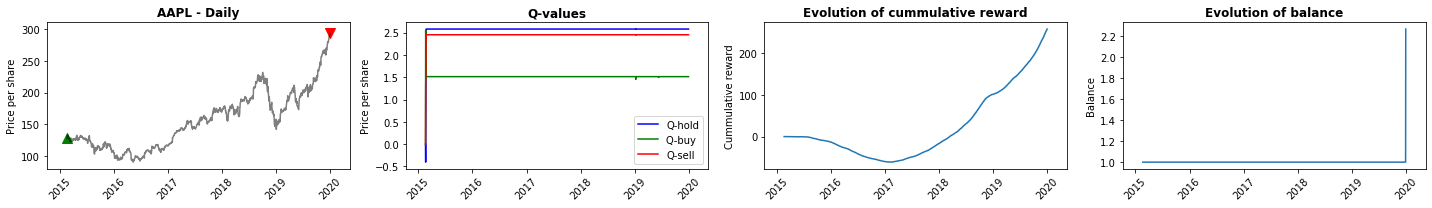

In [198]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_32_1.png')
    fig.show()

2020-07-19 18:28:39,650 : INFO Creating environment
2020-07-19 18:28:39,651 : INFO Start downloading data from GE


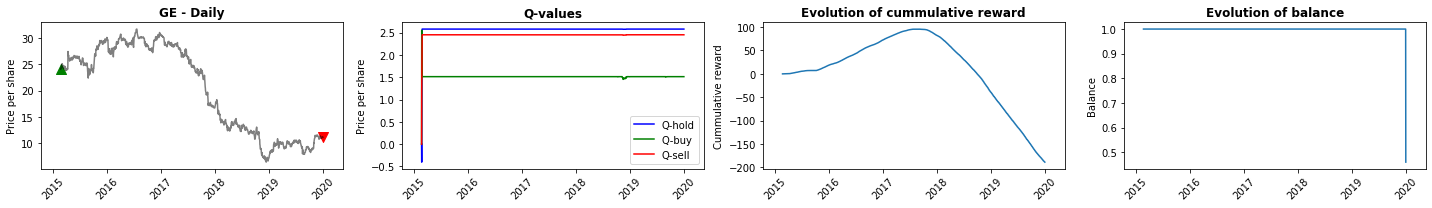

In [199]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_32_2.png')
    fig.show()

2020-07-19 18:28:51,059 : INFO Creating environment
2020-07-19 18:28:51,060 : INFO Start downloading data from CAT


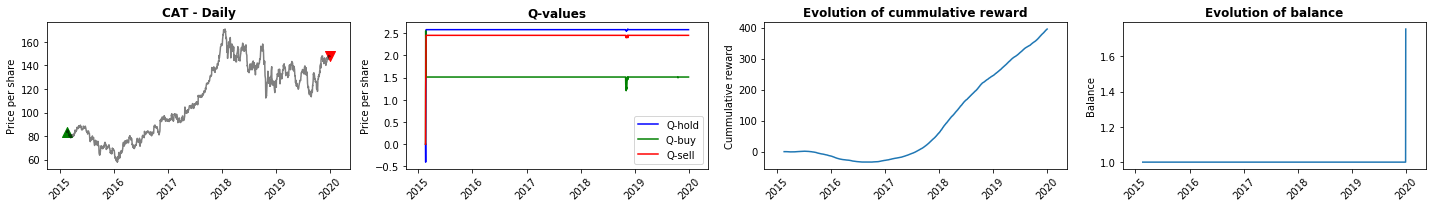

In [200]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_2_32_3.png')
    fig.show()

### DDQL [3]

#### time\_horizon = 8

2020-07-19 18:29:47,032 : INFO Creating environment
2020-07-19 18:29:47,033 : INFO Start downloading data from AAPL
2020-07-19 18:29:47,733 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 8)            0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           288         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 18:29:48,823 : INFO Creating agent
2020-07-19 18:30:00,454 : INFO Training DDQL
2020-07-19 18:30:00,460 : DEBUG Running episode 0/50
2020-07-19 18:36:32,463 : DEBUG Running episode 10/50
2020-07-19 18:43:53,107 : DEBUG Running episode 20/50
2020-07-19 18:51:11,494 : DEBUG Running episode 30/50
2020-07-19 18:58:50,300 : DEBUG Running episode 40/50


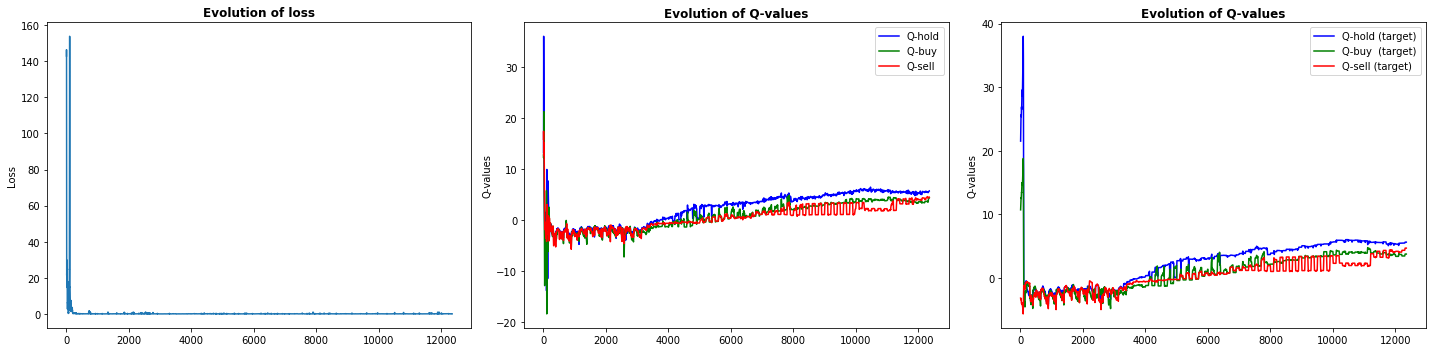

In [201]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon,
                          n_features   = env.n_features,
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 19:07:30,783 : INFO Creating environment
2020-07-19 19:07:32,410 : INFO Start downloading data from AAPL


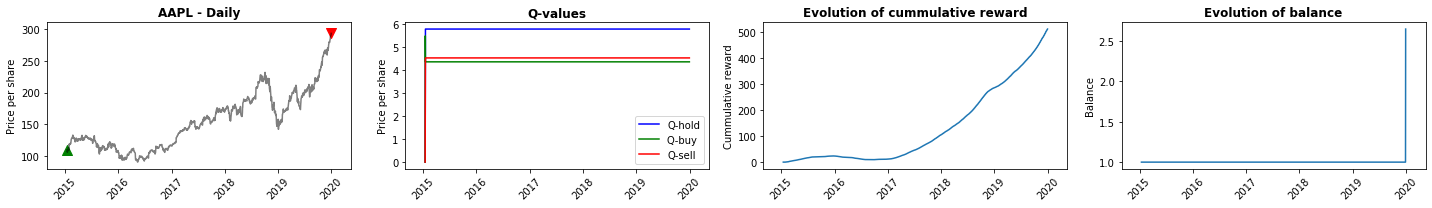

In [202]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_8_1.png')
    fig.show()

2020-07-19 19:07:49,405 : INFO Creating environment
2020-07-19 19:07:49,406 : INFO Start downloading data from GE


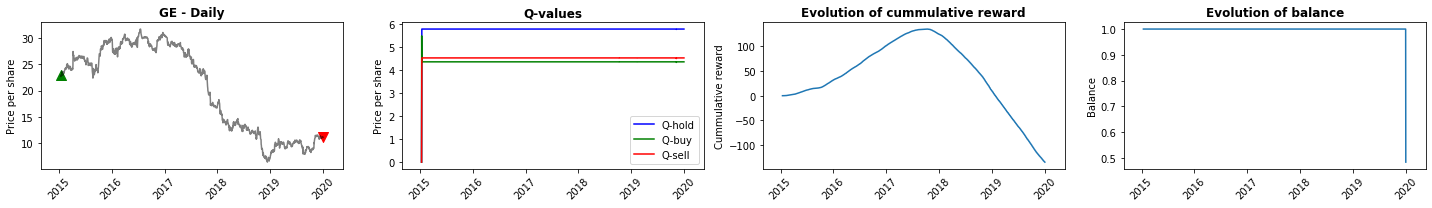

In [203]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_8_2.png')
    fig.show()

2020-07-19 19:08:05,243 : INFO Creating environment
2020-07-19 19:08:05,245 : INFO Start downloading data from CAT


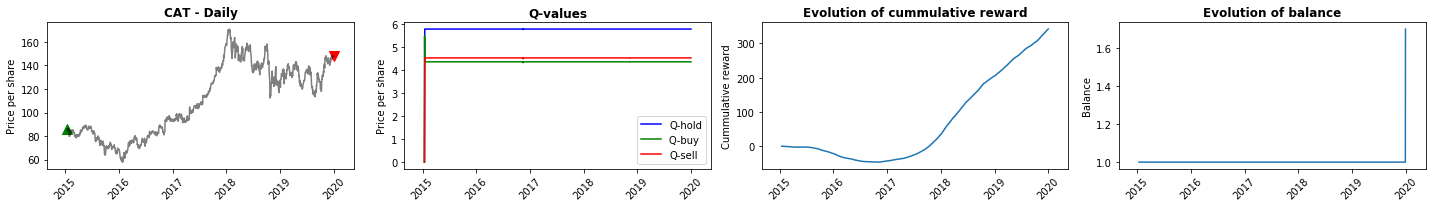

In [204]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-19 19:13:53,652 : INFO Creating environment
2020-07-19 19:13:53,654 : INFO Start downloading data from AAPL
2020-07-19 19:13:55,404 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 16)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           544         Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 19:13:56,501 : INFO Creating agent
2020-07-19 19:14:10,380 : INFO Training DDQL
2020-07-19 19:14:10,384 : DEBUG Running episode 0/50
2020-07-19 19:21:37,993 : DEBUG Running episode 10/50
2020-07-19 19:29:55,805 : DEBUG Running episode 20/50
2020-07-19 19:38:48,470 : DEBUG Running episode 30/50
2020-07-19 19:47:43,803 : DEBUG Running episode 40/50


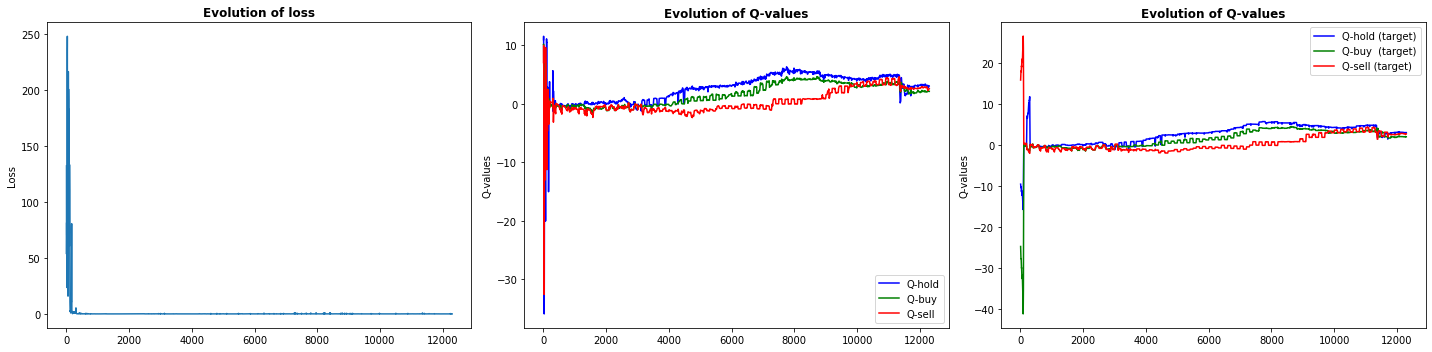

In [205]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon,
                          n_features   = env.n_features,
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 19:57:11,336 : INFO Creating environment
2020-07-19 19:57:11,337 : INFO Start downloading data from AAPL


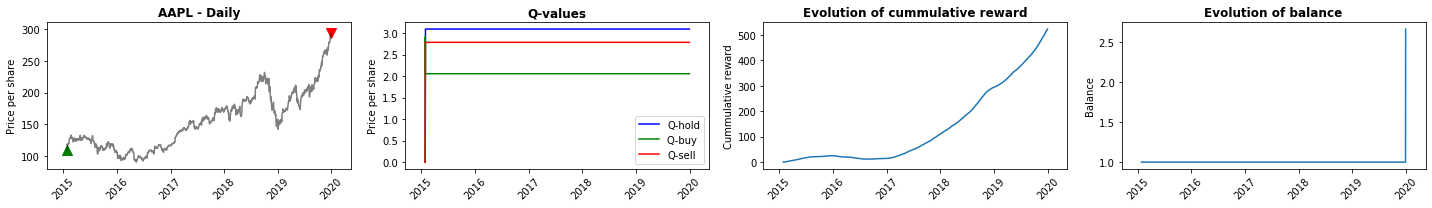

In [206]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_16_1.png')
    fig.show()

2020-07-19 19:57:27,731 : INFO Creating environment
2020-07-19 19:57:27,732 : INFO Start downloading data from GE


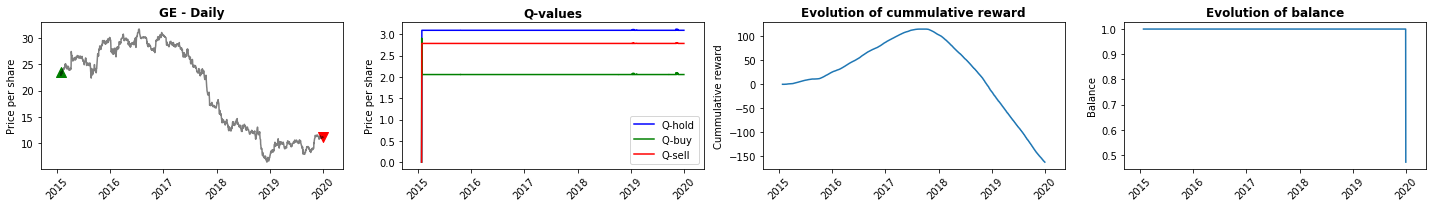

In [207]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_16_2.png')
    fig.show()

2020-07-19 19:57:44,756 : INFO Creating environment
2020-07-19 19:57:44,757 : INFO Start downloading data from CAT


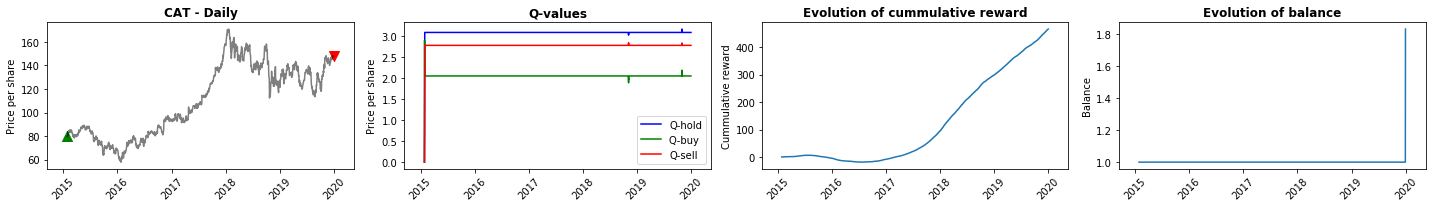

In [208]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-19 19:58:08,519 : INFO Creating environment
2020-07-19 19:58:08,521 : INFO Start downloading data from AAPL
2020-07-19 19:58:09,942 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-07-19 19:58:11,038 : INFO Creating agent
2020-07-19 19:58:27,955 : INFO Training DDQL
2020-07-19 19:58:27,961 : DEBUG Running episode 0/50
2020-07-19 20:08:06,820 : DEBUG Running episode 10/50
2020-07-19 20:17:59,081 : DEBUG Running episode 20/50
2020-07-19 20:27:21,728 : DEBUG Running episode 30/50
2020-07-19 20:38:02,835 : DEBUG Running episode 40/50


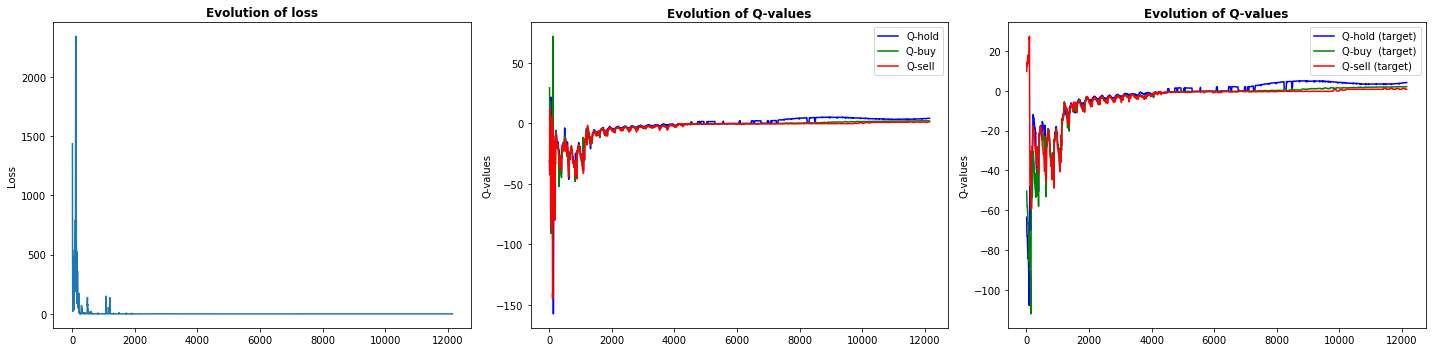

In [209]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon,
                          n_features   = env.n_features,
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 20:48:35,878 : INFO Creating environment
2020-07-19 20:48:37,484 : INFO Start downloading data from AAPL


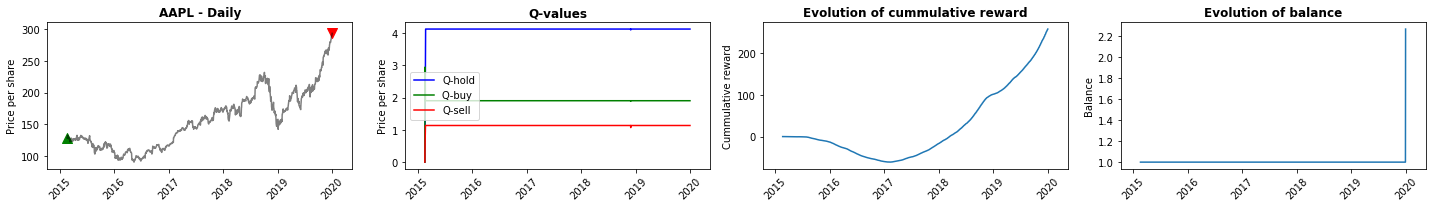

In [210]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_32_1.png')
    fig.show()

2020-07-19 20:48:55,069 : INFO Creating environment
2020-07-19 20:48:55,070 : INFO Start downloading data from GE


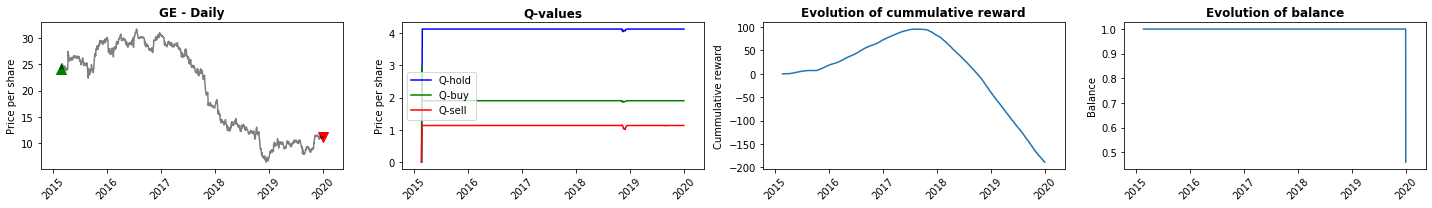

In [211]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_32_2.png')
    fig.show()

2020-07-19 20:49:12,483 : INFO Creating environment
2020-07-19 20:49:12,484 : INFO Start downloading data from CAT


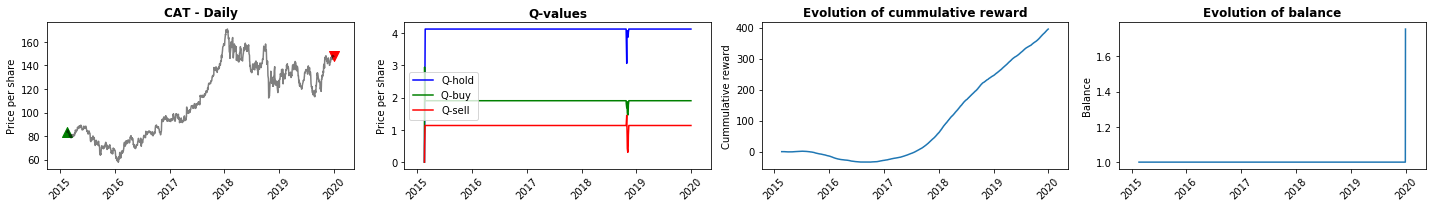

In [212]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_1_3_32_3.png')
    fig.show()

## Recurrent Neural Network

### DQL [1]

#### time\_horizon = 8

2020-07-19 21:18:24,861 : INFO Creating environment
2020-07-19 21:18:24,863 : INFO Start downloading data from AAPL
2020-07-19 21:18:25,860 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 8, 16)        640         Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 8)            800         Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-19 21:18:28,645 : INFO Creating agent
2020-07-19 21:18:58,054 : INFO Training DQL
2020-07-19 21:18:58,062 : DEBUG Running episode 0/100
2020-07-19 21:26:06,039 : DEBUG Running episode 10/100
2020-07-19 21:32:50,360 : DEBUG Running episode 20/100
2020-07-19 21:39:37,986 : DEBUG Running episode 30/100
2020-07-19 21:46:25,132 : DEBUG Running episode 40/100
2020-07-19 21:53:10,361 : DEBUG Running episode 50/100
2020-07-19 22:00:00,155 : DEBUG Running episode 60/100
2020-07-19 22:06:47,146 : DEBUG Running episode 70/100
2020-07-19 22:13:40,704 : DEBUG Running episode 80/100
2020-07-19 22:20:18,847 : DEBUG Running episode 90/100


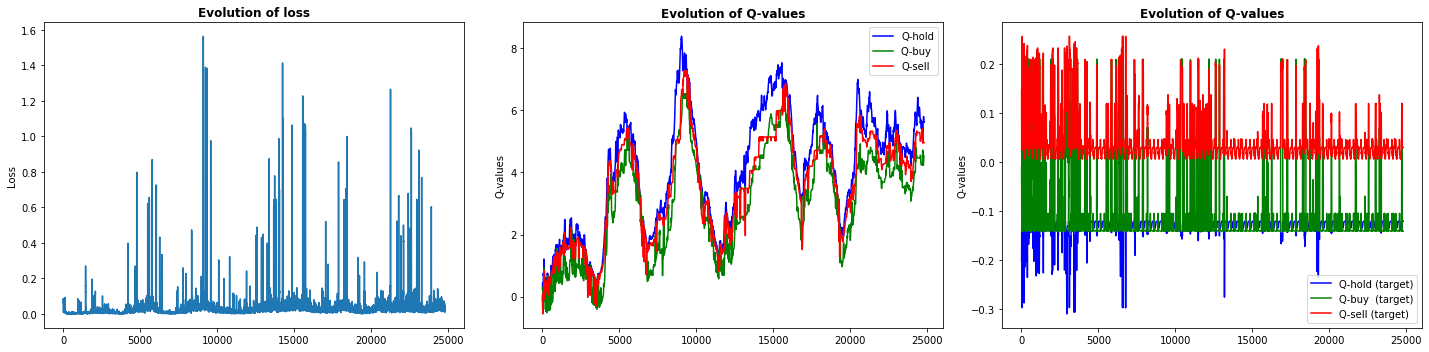

In [218]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_2_model_1.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-19 22:27:08,216 : INFO Creating environment
2020-07-19 22:27:08,218 : INFO Start downloading data from AAPL


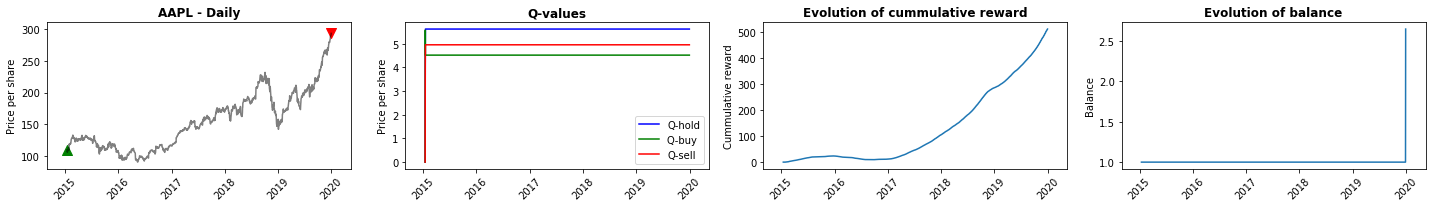

In [219]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_8_1.png')
    fig.show()

2020-07-19 22:27:38,558 : INFO Creating environment
2020-07-19 22:27:38,559 : INFO Start downloading data from GE


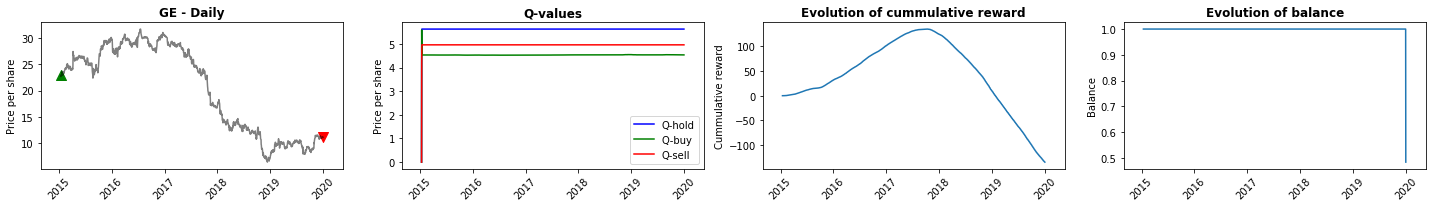

In [220]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_8_2.png')
    fig.show()

2020-07-19 22:28:07,801 : INFO Creating environment
2020-07-19 22:28:07,802 : INFO Start downloading data from CAT


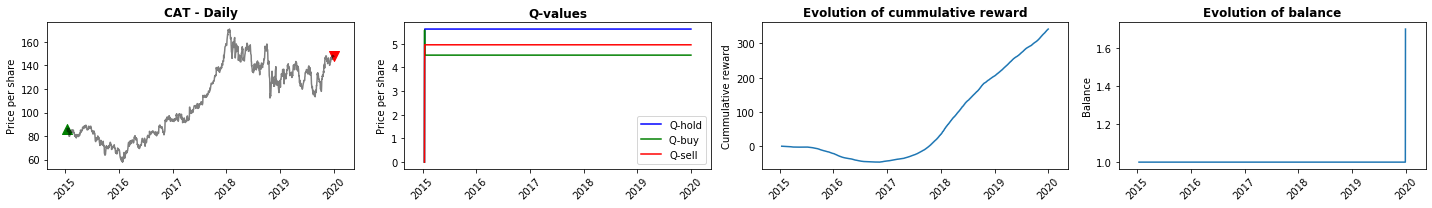

In [221]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-21 17:27:57,510 : INFO Creating environment
2020-07-21 17:27:57,511 : INFO Start downloading data from AAPL
2020-07-21 17:27:58,351 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 16, 32)       2304        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 16)           3136        Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-21 17:28:00,065 : INFO Creating agent
2020-07-21 17:28:01,216 : INFO Training DQL
2020-07-21 17:28:01,220 : DEBUG Running episode 0/100
2020-07-21 17:30:08,053 : DEBUG Running episode 10/100
2020-07-21 17:32:17,565 : DEBUG Running episode 20/100
2020-07-21 17:34:27,597 : DEBUG Running episode 30/100
2020-07-21 17:36:37,682 : DEBUG Running episode 40/100
2020-07-21 17:38:47,572 : DEBUG Running episode 50/100
2020-07-21 17:40:58,787 : DEBUG Running episode 60/100
2020-07-21 17:43:08,750 : DEBUG Running episode 70/100
2020-07-21 17:45:19,322 : DEBUG Running episode 80/100
2020-07-21 17:47:29,727 : DEBUG Running episode 90/100


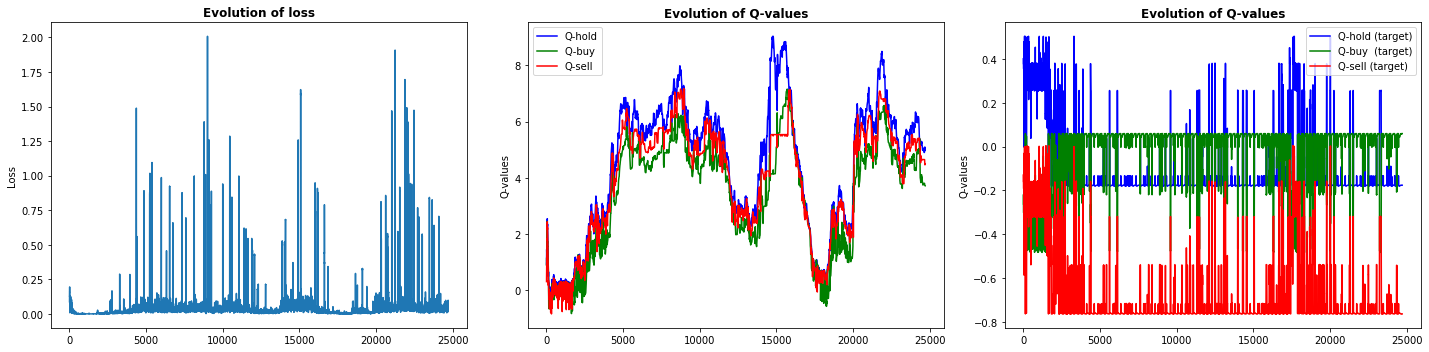

In [16]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_2_model_2.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-21 17:49:54,835 : INFO Creating environment
2020-07-21 17:49:54,836 : INFO Start downloading data from AAPL


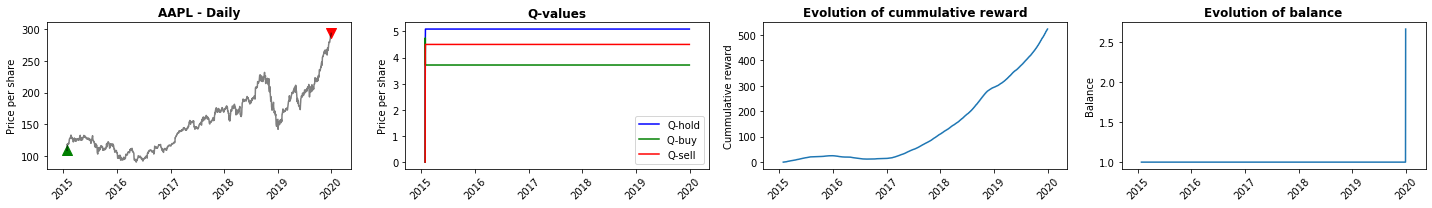

In [17]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_16_1.png')
    fig.show()

2020-07-21 17:50:05,998 : INFO Creating environment
2020-07-21 17:50:05,999 : INFO Start downloading data from GE


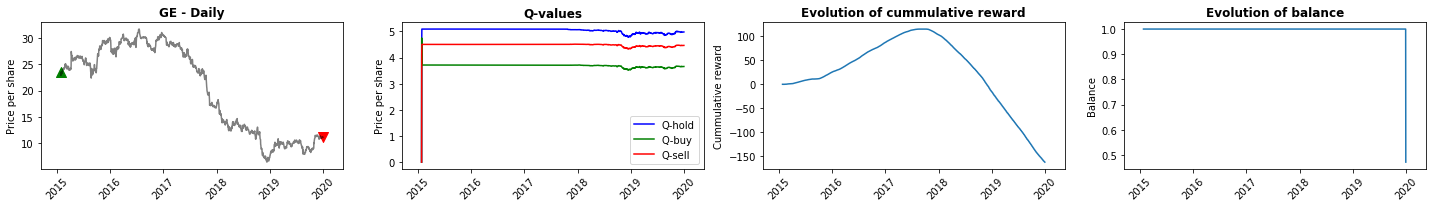

In [18]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_16_2.png')
    fig.show()

2020-07-21 17:50:17,163 : INFO Creating environment
2020-07-21 17:50:17,164 : INFO Start downloading data from CAT


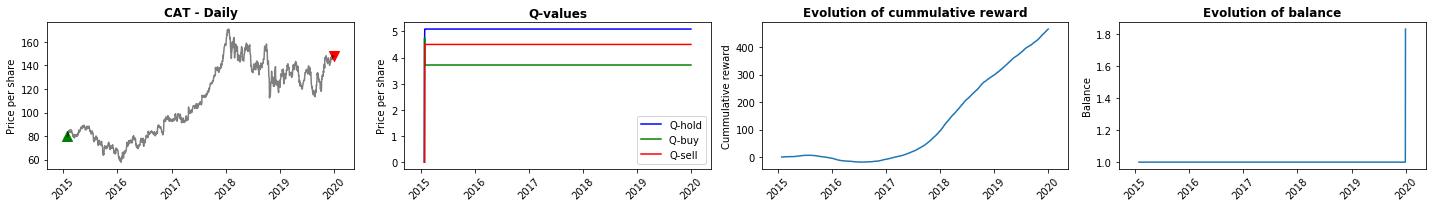

In [19]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-21 20:28:06,932 : INFO Creating environment
2020-07-21 20:28:06,933 : INFO Start downloading data from AAPL
2020-07-21 20:28:08,019 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-21 20:28:09,700 : INFO Creating agent
2020-07-21 20:28:13,681 : INFO Training DQL
2020-07-21 20:28:13,686 : DEBUG Running episode 0/100
2020-07-21 20:32:33,119 : DEBUG Running episode 10/100
2020-07-21 20:36:39,453 : DEBUG Running episode 20/100
2020-07-21 20:41:18,754 : DEBUG Running episode 30/100
2020-07-21 20:45:29,676 : DEBUG Running episode 40/100
2020-07-21 20:50:04,782 : DEBUG Running episode 50/100
2020-07-21 20:54:18,715 : DEBUG Running episode 60/100
2020-07-21 20:58:54,585 : DEBUG Running episode 70/100
2020-07-21 21:03:18,859 : DEBUG Running episode 80/100
2020-07-21 21:07:31,039 : DEBUG Running episode 90/100


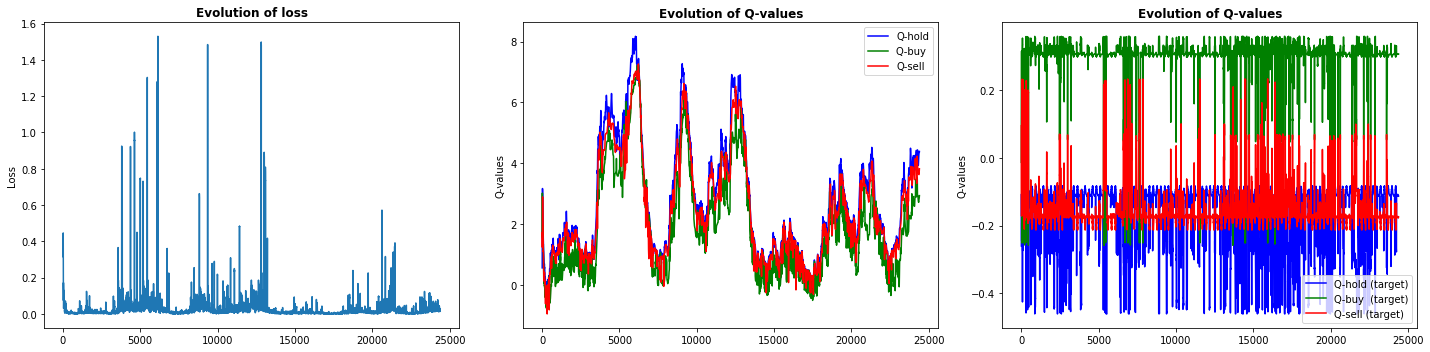

In [33]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Plot model
tf.keras.utils.plot_model(model, to_file = 'exp_2_model_3.png', show_shapes = True)

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-21 21:11:57,265 : INFO Creating environment
2020-07-21 21:11:57,266 : INFO Start downloading data from AAPL


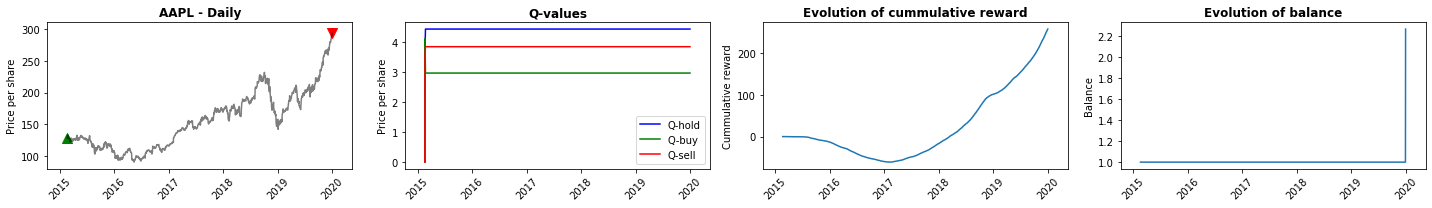

In [34]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_32_1.png')
    fig.show()

2020-07-21 21:12:13,155 : INFO Creating environment
2020-07-21 21:12:13,156 : INFO Start downloading data from GE


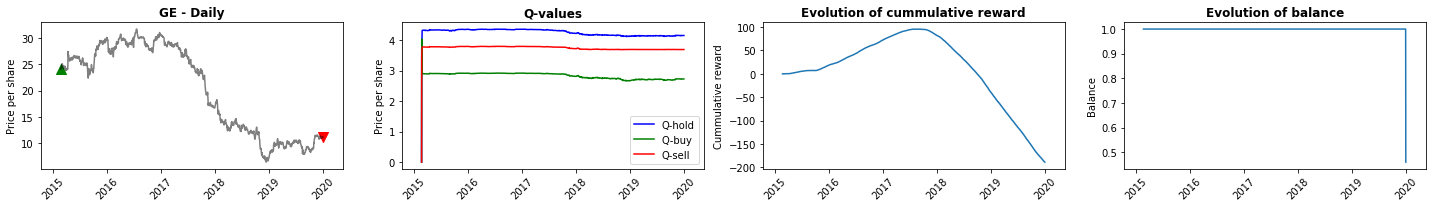

In [35]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_32_2.png')
    fig.show()

2020-07-21 21:12:28,903 : INFO Creating environment
2020-07-21 21:12:28,904 : INFO Start downloading data from CAT


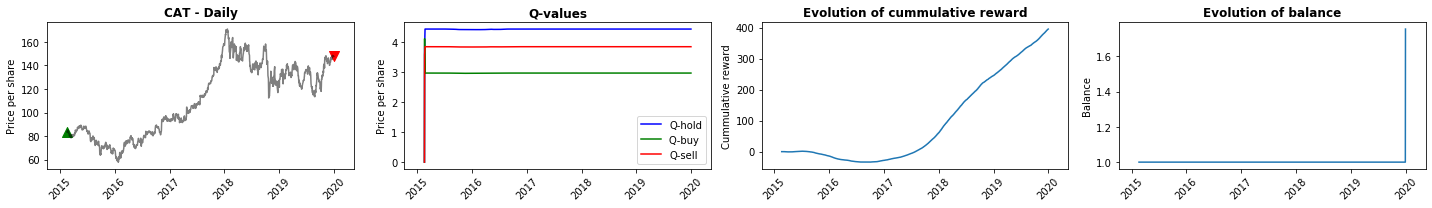

In [36]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_1_32_3.png')
    fig.show()

### DQL [2]

#### time\_horizon = 8

2020-07-21 22:11:29,036 : INFO Creating environment
2020-07-21 22:11:29,038 : INFO Start downloading data from AAPL
2020-07-21 22:11:29,963 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 8, 16)        640         Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 8)            800         Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-21 22:11:31,979 : INFO Creating agent
2020-07-21 22:11:38,545 : INFO Training DQL with target network
2020-07-21 22:11:38,551 : DEBUG Running episode 0/100
2020-07-21 22:15:13,476 : DEBUG Running episode 10/100
2020-07-21 22:18:46,138 : DEBUG Running episode 20/100
2020-07-21 22:22:24,623 : DEBUG Running episode 30/100
2020-07-21 22:26:01,111 : DEBUG Running episode 40/100
2020-07-21 22:29:38,434 : DEBUG Running episode 50/100
2020-07-21 22:33:24,823 : DEBUG Running episode 60/100
2020-07-21 22:37:11,756 : DEBUG Running episode 70/100
2020-07-21 22:40:46,696 : DEBUG Running episode 80/100
2020-07-21 22:44:19,796 : DEBUG Running episode 90/100


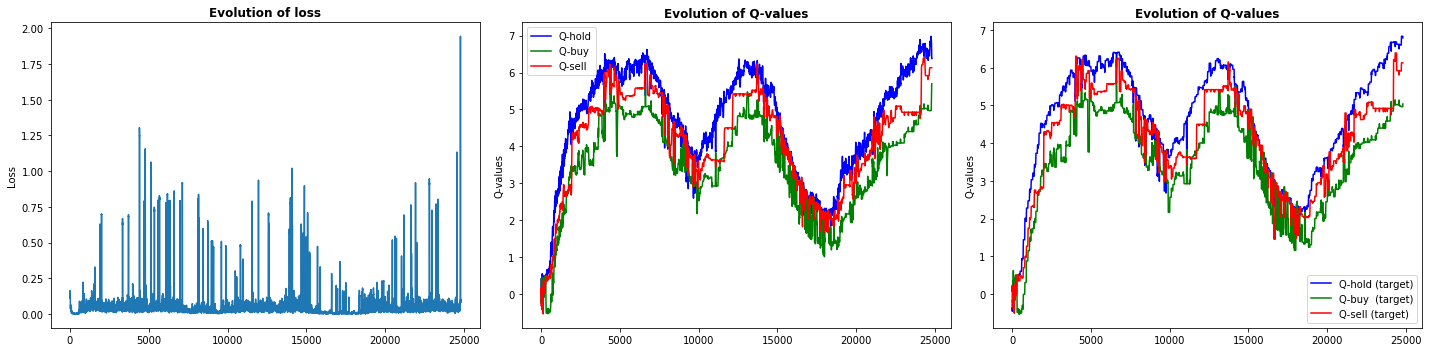

In [37]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-21 22:48:26,286 : INFO Creating environment
2020-07-21 22:48:26,288 : INFO Start downloading data from AAPL


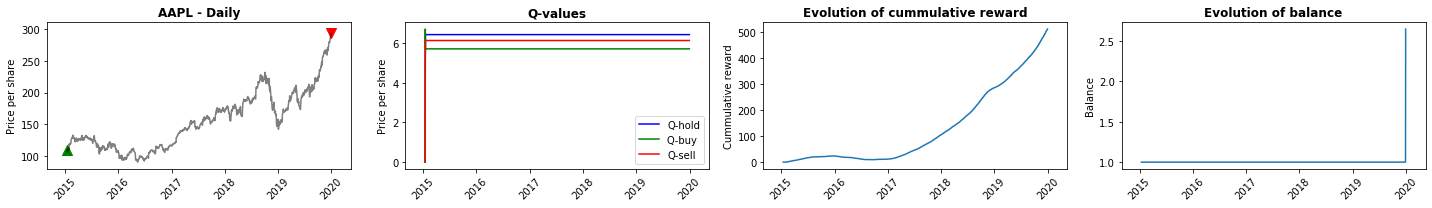

In [38]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_8_1.png')
    fig.show()

2020-07-21 22:48:48,496 : INFO Creating environment
2020-07-21 22:48:48,497 : INFO Start downloading data from GE


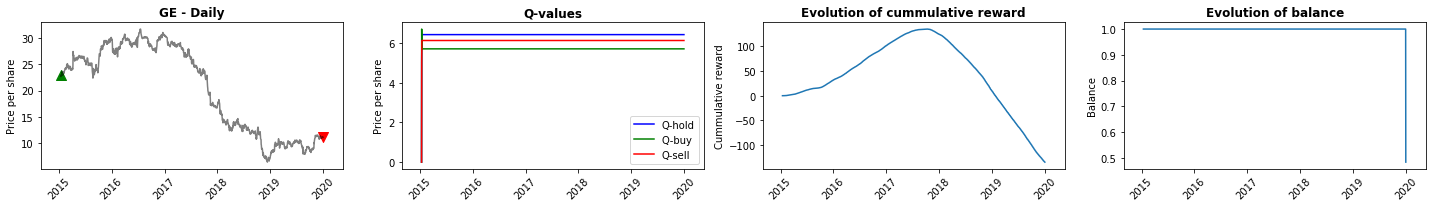

In [39]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_8_2.png')
    fig.show()

2020-07-21 22:49:10,127 : INFO Creating environment
2020-07-21 22:49:10,129 : INFO Start downloading data from CAT


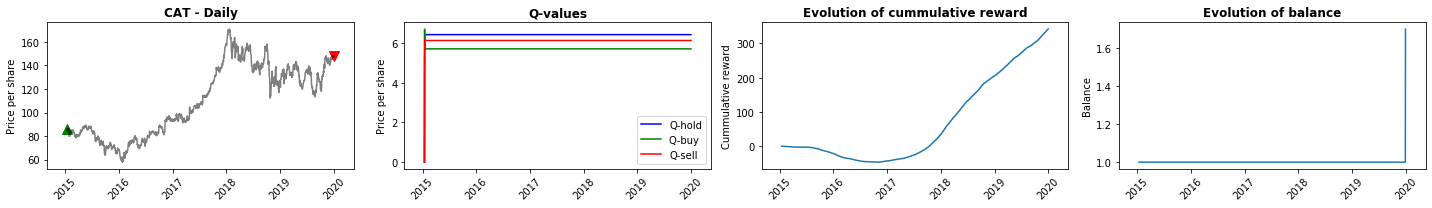

In [40]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-21 23:08:28,077 : INFO Creating environment
2020-07-21 23:08:28,079 : INFO Start downloading data from AAPL
2020-07-21 23:08:44,539 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 16, 32)       2304        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 16)           3136        Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-21 23:08:46,590 : INFO Creating agent
2020-07-21 23:08:53,554 : INFO Training DQL with target network
2020-07-21 23:08:53,560 : DEBUG Running episode 0/100
2020-07-21 23:13:37,722 : DEBUG Running episode 10/100
2020-07-21 23:18:26,019 : DEBUG Running episode 20/100
2020-07-21 23:23:16,301 : DEBUG Running episode 30/100
2020-07-22 07:30:35,852 : DEBUG Running episode 40/100
2020-07-22 07:35:27,987 : DEBUG Running episode 50/100
2020-07-22 07:40:20,408 : DEBUG Running episode 60/100
2020-07-22 07:45:15,941 : DEBUG Running episode 70/100
2020-07-22 07:50:10,473 : DEBUG Running episode 80/100
2020-07-22 07:55:05,457 : DEBUG Running episode 90/100


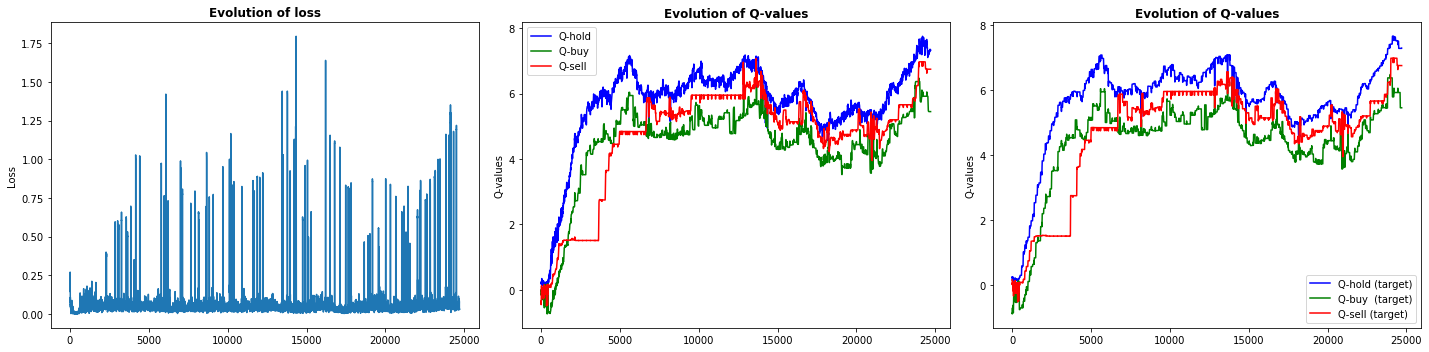

In [41]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-22 08:00:30,942 : INFO Creating environment
2020-07-22 08:00:30,944 : INFO Start downloading data from AAPL


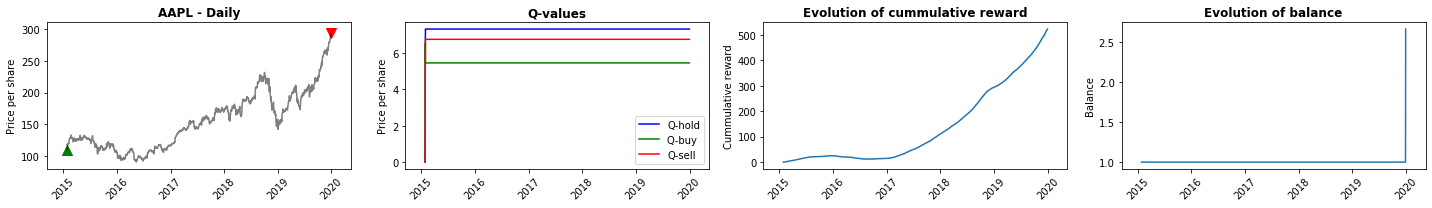

In [42]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_16_1.png')
    fig.show()

2020-07-22 08:00:54,864 : INFO Creating environment
2020-07-22 08:00:54,866 : INFO Start downloading data from GE


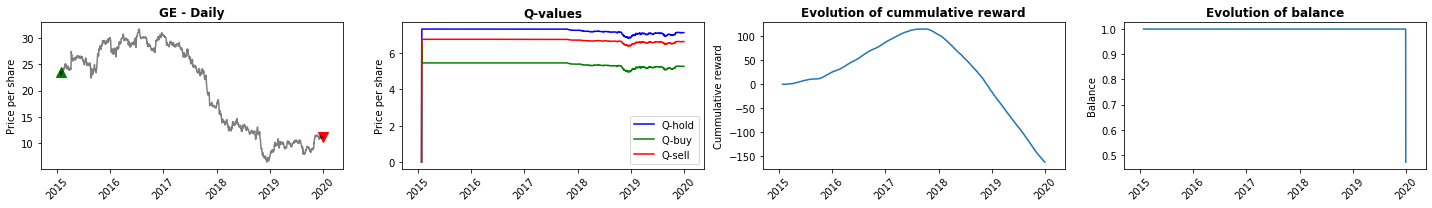

In [43]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_16_2.png')
    fig.show()

2020-07-22 08:01:18,178 : INFO Creating environment
2020-07-22 08:01:18,179 : INFO Start downloading data from CAT


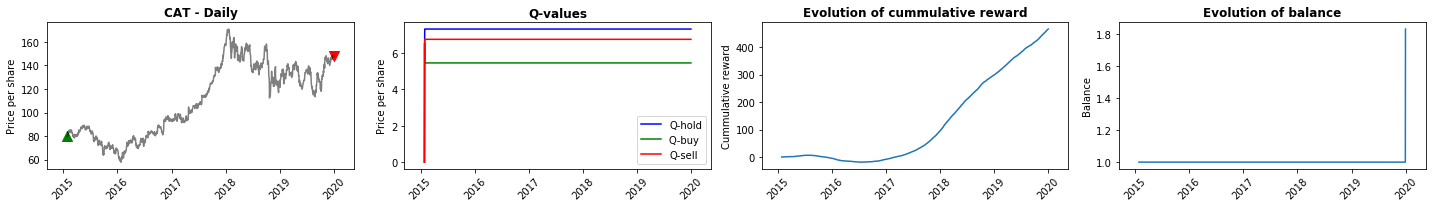

In [44]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-22 08:01:41,549 : INFO Creating environment
2020-07-22 08:01:41,550 : INFO Start downloading data from AAPL
2020-07-22 08:01:42,131 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-22 08:01:44,101 : INFO Creating agent
2020-07-22 08:01:51,076 : INFO Training DQL with target network
2020-07-22 08:01:51,082 : DEBUG Running episode 0/100
2020-07-22 08:09:19,967 : DEBUG Running episode 10/100
2020-07-22 08:16:57,370 : DEBUG Running episode 20/100
2020-07-22 08:24:54,492 : DEBUG Running episode 30/100
2020-07-22 08:32:55,853 : DEBUG Running episode 40/100
2020-07-22 08:40:58,536 : DEBUG Running episode 50/100
2020-07-22 08:49:03,806 : DEBUG Running episode 60/100
2020-07-22 08:57:05,119 : DEBUG Running episode 70/100
2020-07-22 09:03:46,565 : DEBUG Running episode 80/100
2020-07-22 09:07:38,191 : DEBUG Running episode 90/100


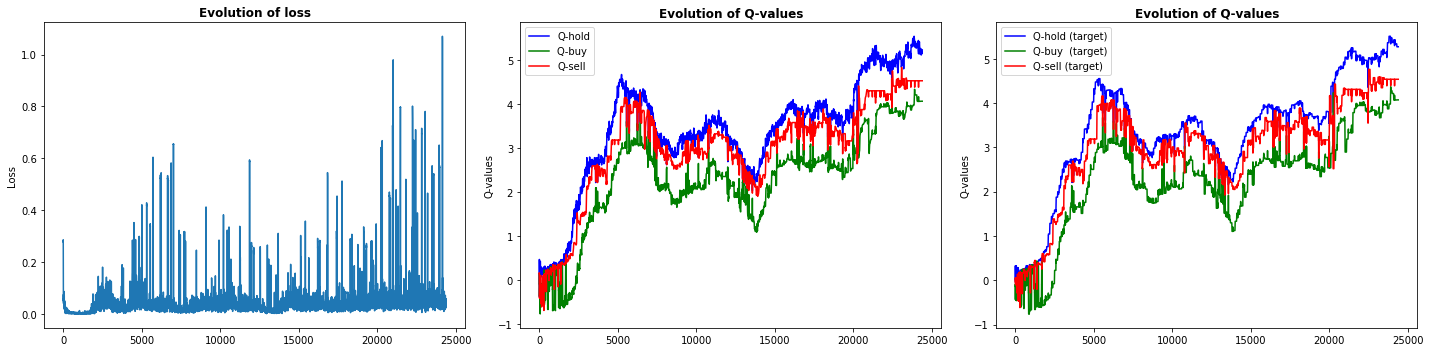

In [45]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_deep_q_learning_with_target_network(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-22 09:16:59,392 : INFO Creating environment
2020-07-22 09:16:59,392 : INFO Start downloading data from AAPL


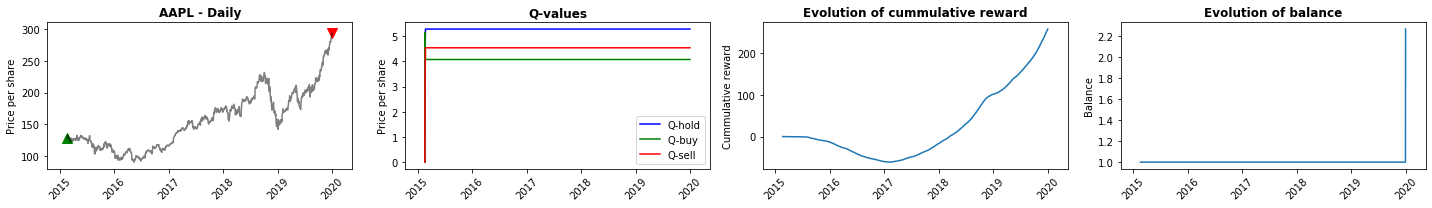

In [46]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_32_1.png')
    fig.show()

2020-07-22 09:17:14,162 : INFO Creating environment
2020-07-22 09:17:14,163 : INFO Start downloading data from GE


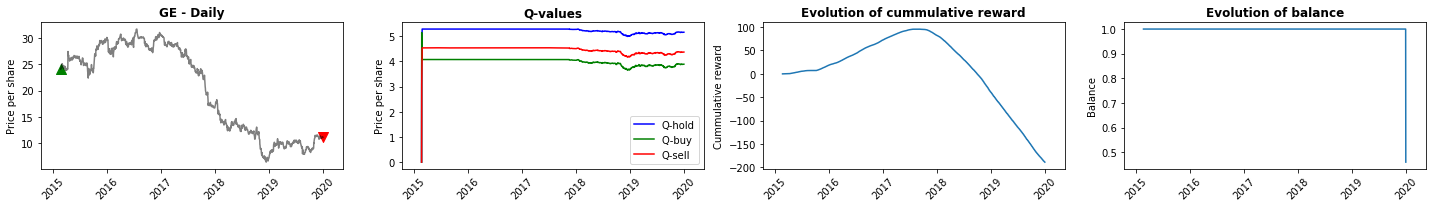

In [47]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_32_2.png')
    fig.show()

2020-07-22 09:17:29,804 : INFO Creating environment
2020-07-22 09:17:29,805 : INFO Start downloading data from CAT


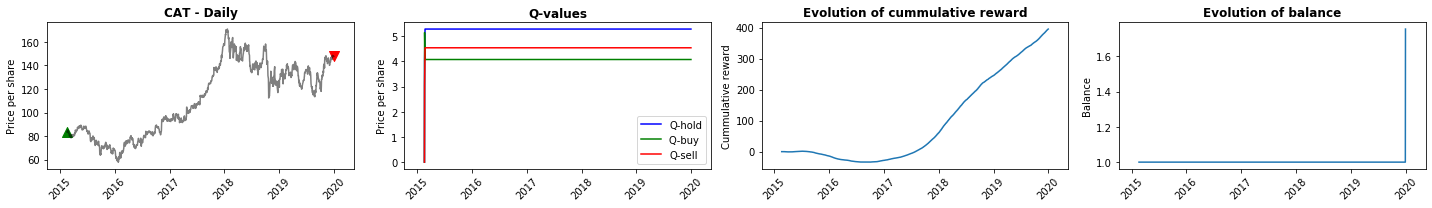

In [48]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_2_32_3.png')
    fig.show()

### DDQL [3]

#### time\_horizon = 8

2020-07-22 11:47:25,769 : INFO Creating environment
2020-07-22 11:47:25,785 : INFO Start downloading data from AAPL
2020-07-22 11:47:27,920 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 8, 16)        640         Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 8)            800         Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-22 11:47:29,377 : INFO Creating agent
2020-07-22 11:47:34,219 : INFO Training DDQL
2020-07-22 11:47:34,224 : DEBUG Running episode 0/100
2020-07-22 11:51:35,069 : DEBUG Running episode 10/100
2020-07-22 11:56:47,688 : DEBUG Running episode 20/100
2020-07-22 12:03:12,328 : DEBUG Running episode 30/100
2020-07-22 12:10:54,810 : DEBUG Running episode 40/100
2020-07-22 12:20:08,876 : DEBUG Running episode 50/100
2020-07-22 12:30:38,067 : DEBUG Running episode 60/100
2020-07-22 12:42:33,199 : DEBUG Running episode 70/100
2020-07-22 13:08:23,311 : DEBUG Running episode 80/100
2020-07-22 13:23:08,576 : DEBUG Running episode 90/100


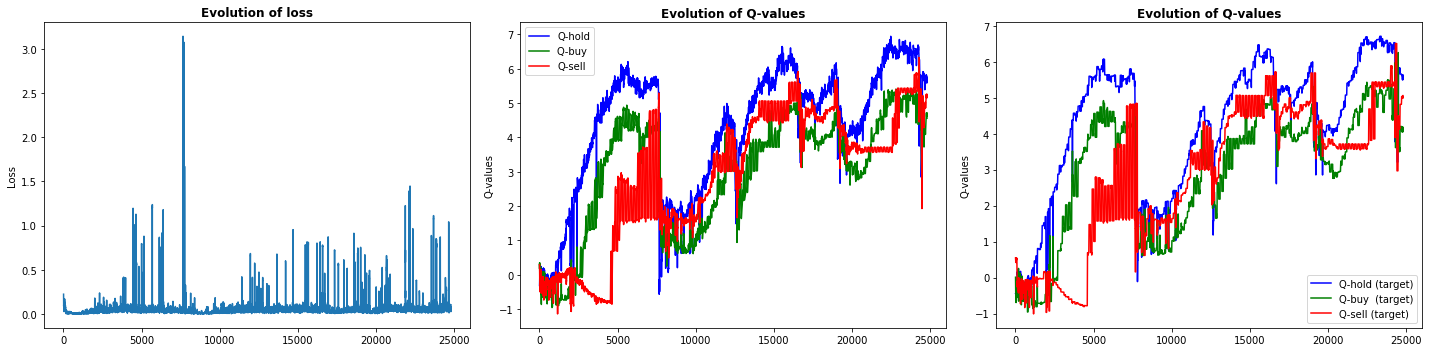

In [49]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-22 14:00:52,414 : INFO Creating environment
2020-07-22 14:00:52,771 : INFO Start downloading data from AAPL


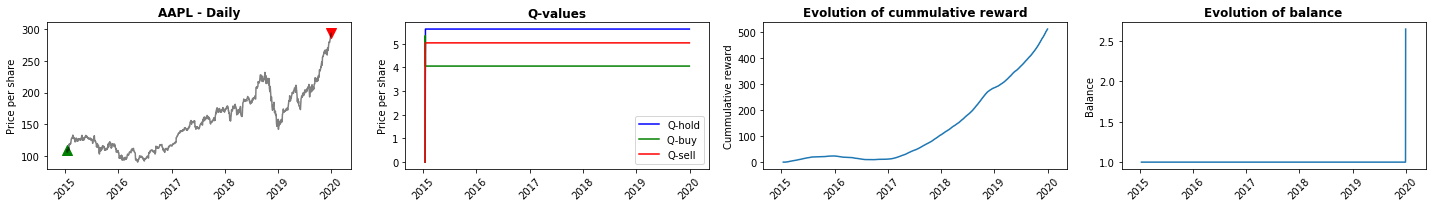

In [50]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_8_1.png')
    fig.show()

2020-07-22 14:01:16,789 : INFO Creating environment
2020-07-22 14:01:16,791 : INFO Start downloading data from GE


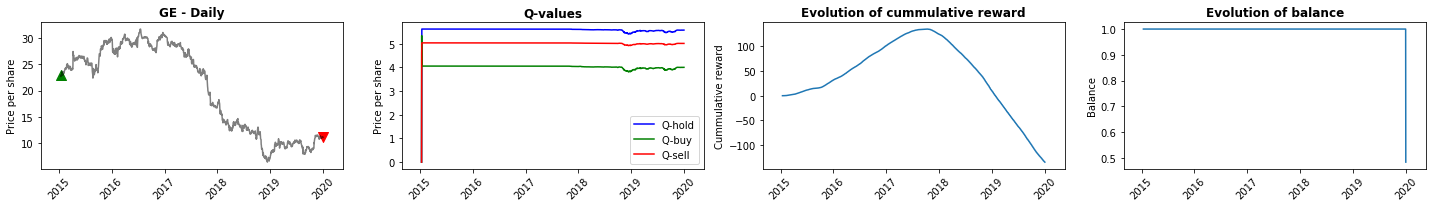

In [51]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_8_2.png')
    fig.show()

2020-07-22 14:01:40,212 : INFO Creating environment
2020-07-22 14:01:40,213 : INFO Start downloading data from CAT


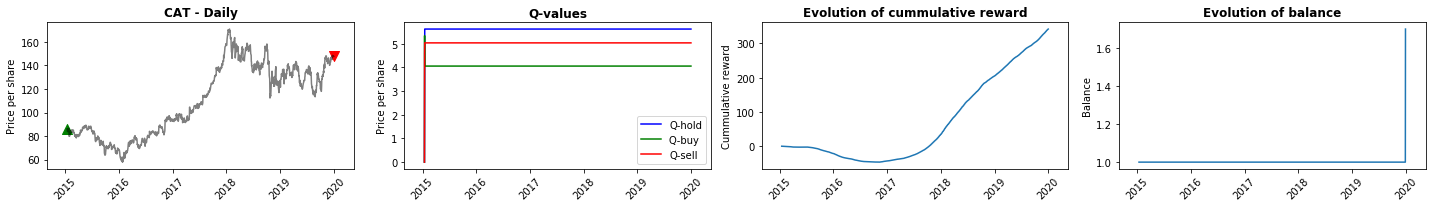

In [52]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 8, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_8_3.png')
    fig.show()

#### time\_horizon = 16

2020-07-24 20:58:38,713 : INFO Creating environment
2020-07-24 20:58:38,714 : INFO Start downloading data from AAPL
2020-07-24 20:58:39,414 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 16, 32)       2304        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 16)           3136        Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-24 20:58:40,894 : INFO Creating agent
2020-07-24 20:59:14,588 : INFO Training DDQL
2020-07-24 20:59:14,593 : DEBUG Running episode 0/100
2020-07-24 21:16:29,432 : DEBUG Running episode 10/100
2020-07-24 21:45:19,975 : DEBUG Running episode 20/100
2020-07-24 22:15:46,712 : DEBUG Running episode 30/100
2020-07-24 22:48:17,776 : DEBUG Running episode 40/100
2020-07-24 23:26:57,031 : DEBUG Running episode 50/100
2020-07-25 00:02:24,712 : DEBUG Running episode 60/100
2020-07-25 00:31:32,154 : DEBUG Running episode 70/100
2020-07-25 01:00:27,352 : DEBUG Running episode 80/100
2020-07-25 01:36:37,359 : DEBUG Running episode 90/100


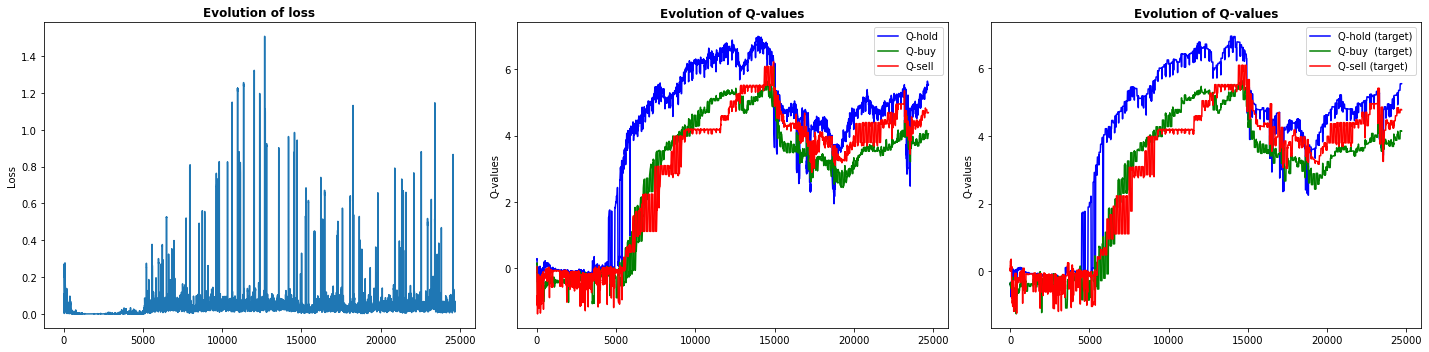

In [24]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-25 02:08:38,201 : INFO Creating environment
2020-07-25 02:08:40,045 : INFO Start downloading data from AAPL


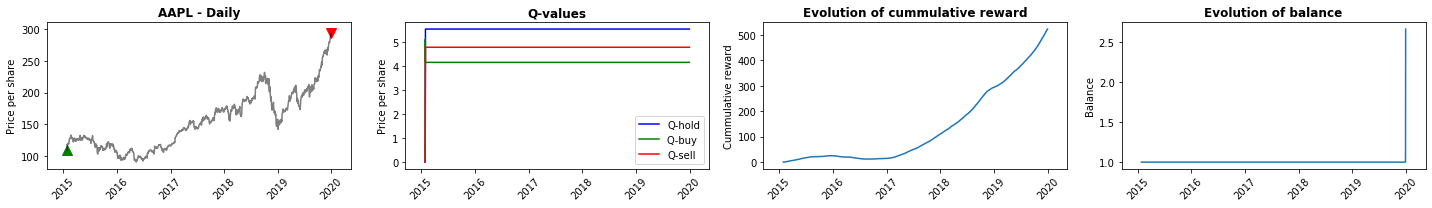

In [25]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_16_1.png')
    fig.show()

2020-07-25 02:09:02,716 : INFO Creating environment
2020-07-25 02:09:02,717 : INFO Start downloading data from GE


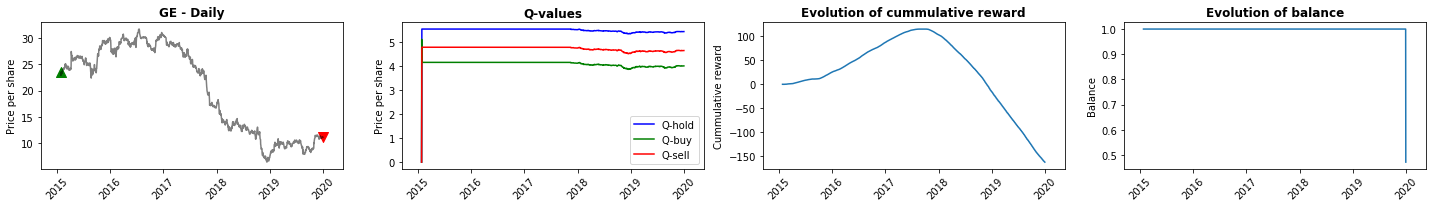

In [26]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_16_2.png')
    fig.show()

2020-07-25 02:09:24,202 : INFO Creating environment
2020-07-25 02:09:24,203 : INFO Start downloading data from CAT


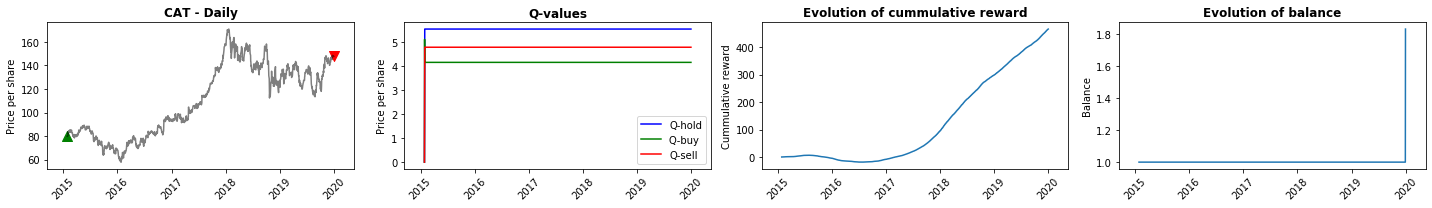

In [27]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 16, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_16_3.png')
    fig.show()

#### time\_horizon = 32

2020-07-22 14:28:00,533 : INFO Creating environment
2020-07-22 14:28:00,822 : INFO Start downloading data from AAPL
2020-07-22 14:28:01,491 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-07-22 14:28:03,578 : INFO Creating agent
2020-07-22 14:28:57,126 : INFO Training DDQL
2020-07-22 14:28:57,447 : DEBUG Running episode 0/100
2020-07-22 16:38:45,059 : DEBUG Running episode 10/100
2020-07-22 17:13:32,557 : DEBUG Running episode 20/100
2020-07-22 17:47:27,842 : DEBUG Running episode 30/100
2020-07-22 18:18:16,197 : DEBUG Running episode 40/100
2020-07-22 18:45:07,401 : DEBUG Running episode 50/100
2020-07-22 19:14:35,484 : DEBUG Running episode 60/100
2020-07-22 19:44:34,666 : DEBUG Running episode 70/100
2020-07-22 20:23:57,821 : DEBUG Running episode 80/100
2020-07-22 20:56:22,186 : DEBUG Running episode 90/100


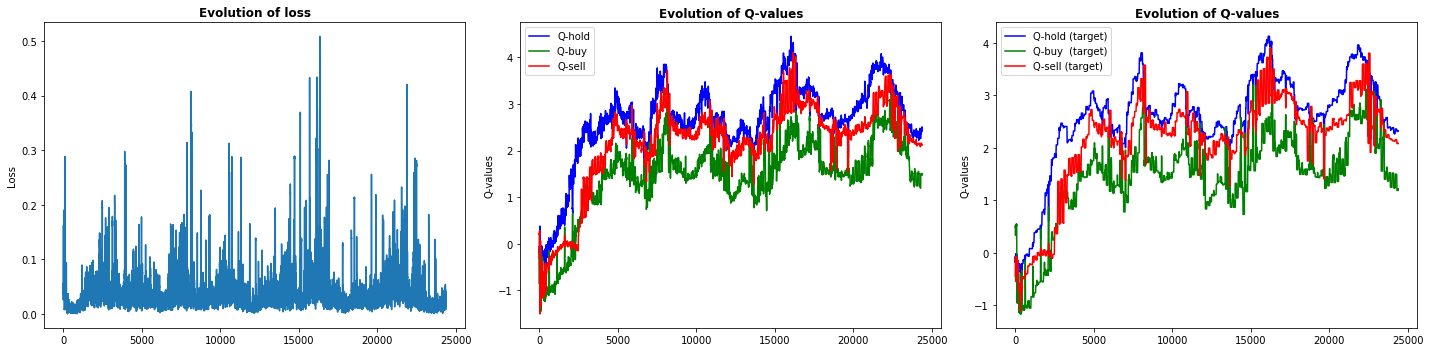

In [53]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 100)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

2020-07-22 21:54:05,450 : INFO Creating environment
2020-07-22 21:54:07,340 : INFO Start downloading data from AAPL


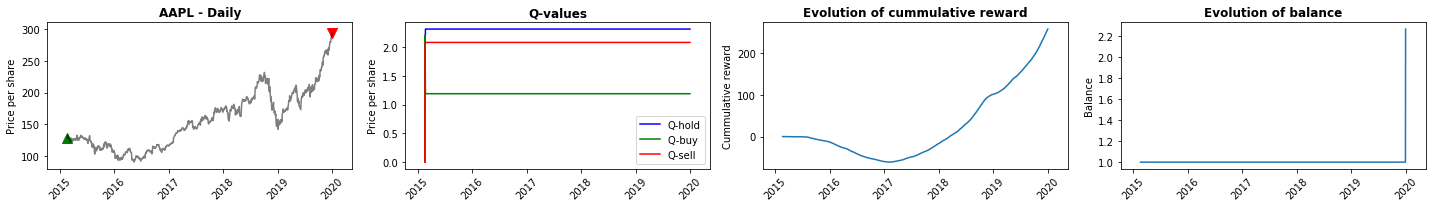

In [54]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_32_1.png')
    fig.show()

2020-07-22 21:54:52,992 : INFO Creating environment
2020-07-22 21:54:52,996 : INFO Start downloading data from GE


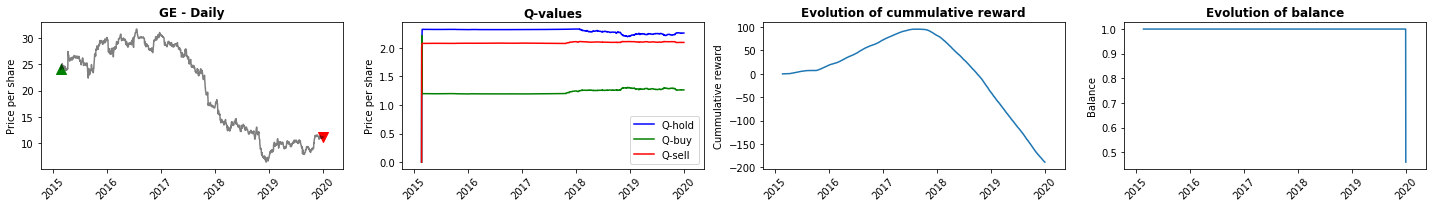

In [55]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_32_2.png')
    fig.show()

2020-07-22 21:55:36,079 : INFO Creating environment
2020-07-22 21:55:36,080 : INFO Start downloading data from CAT


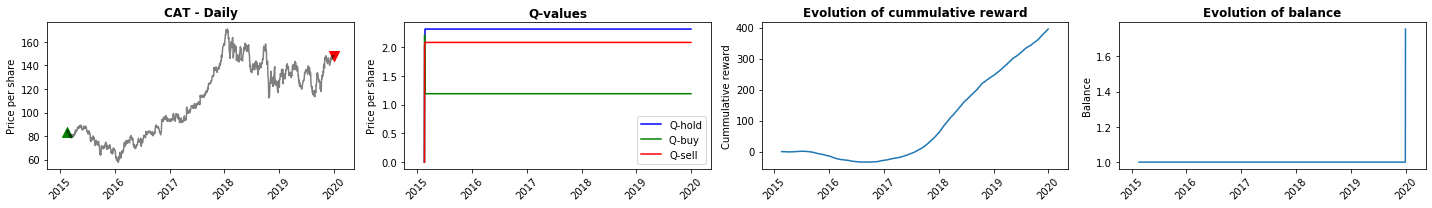

In [56]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 1
                  )

# Run episodes and plot stats
num_episodes = 1
for _ in range(num_episodes):
    fig = run_episode(env, agent)
    fig.savefig('exp_2_3_32_3.png')
    fig.show()

## Feedforward Neural Network with random stock

### AAPL

2020-09-03 19:37:55,232 : INFO Creating environment
2020-09-03 19:37:55,233 : INFO Start downloading data from AAPL
2020-09-03 19:37:56,229 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-09-03 19:37:57,319 : INFO Creating agent
2020-09-03 19:37:57,513 : INFO Training DDQL
2020-09-03 19:37:57,516 : DEBUG Running episode 0/50
2020-09-03 19:38:36,377 : DEBUG Running episode 10/50
2020-09-03 19:39:24,975 : DEBUG Running episode 20/50
2020-09-03 19:40:22,385 : DEBUG Running episode 30/50
2020-09-03 19:41:29,976 : DEBUG Running episode 40/50


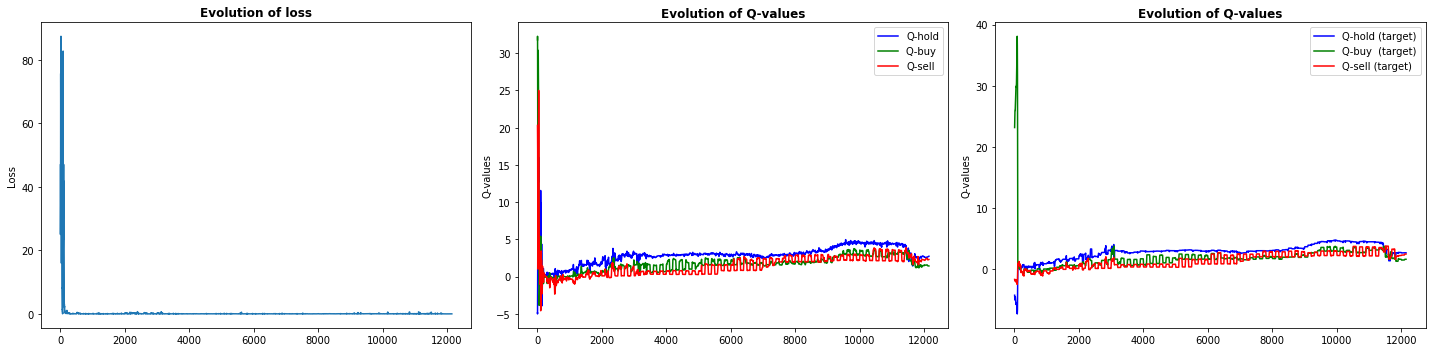

In [16]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [18]:
# Get available stocks
env_test = OneRandomStockEnv(date_start   = datetime(2015, 1, 1), 
                        date_end     = datetime(2019, 12, 31), 
                        time_horizon = 32, 
                        time_skip    = 5
                        )

stocks_list = env_test.data_raw.columns.tolist()
env_test.time_skip = 1

# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]

# Compute mean
balances1 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances1.shape[0]))
print('Mean : {}'.format(balances1.mean()))
print('Std  : {}'.format(balances1.std()))

2020-09-03 20:41:10,471 : INFO Creating environment
2020-09-03 20:41:10,473 : INFO Start downloading data from S&P500
2020-09-03 20:42:11,870 : DEBUG Error downloading data from CARR
2020-09-03 20:43:33,778 : DEBUG Error downloading data from GD
2020-09-03 20:43:48,386 : DEBUG Error downloading data from HAS
2020-09-03 20:43:59,073 : DEBUG Error downloading data from HD
2020-09-03 20:44:00,314 : DEBUG Error downloading data from HON
2020-09-03 20:44:08,396 : DEBUG Error downloading data from HII
2020-09-03 20:44:18,422 : DEBUG Error downloading data from ICE
2020-09-03 20:44:19,346 : DEBUG Error downloading data from IBM
2020-09-03 20:44:22,636 : DEBUG Error downloading data from IFF
2020-09-03 20:44:24,609 : DEBUG Error downloading data from ISRG
2020-09-03 20:44:25,591 : DEBUG Error downloading data from IVZ
2020-09-03 20:44:26,524 : DEBUG Error downloading data from IPGP
2020-09-03 20:44:29,490 : DEBUG Error downloading data from JKHY
2020-09-03 20:44:31,747 : DEBUG Error downloadin

Count: 424
Mean : 1.64750480961258
Std  : 1.013036728349813


### GE

2020-09-03 21:29:36,955 : INFO Creating environment
2020-09-03 21:29:36,956 : INFO Start downloading data from GE
2020-09-03 21:29:37,705 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-09-03 21:29:38,786 : INFO Creating agent
2020-09-03 21:29:40,664 : INFO Training DDQL
2020-09-03 21:29:40,668 : DEBUG Running episode 0/50
2020-09-03 21:31:06,835 : DEBUG Running episode 10/50
2020-09-03 21:32:45,792 : DEBUG Running episode 20/50
2020-09-03 21:34:33,202 : DEBUG Running episode 30/50
2020-09-03 21:36:34,025 : DEBUG Running episode 40/50


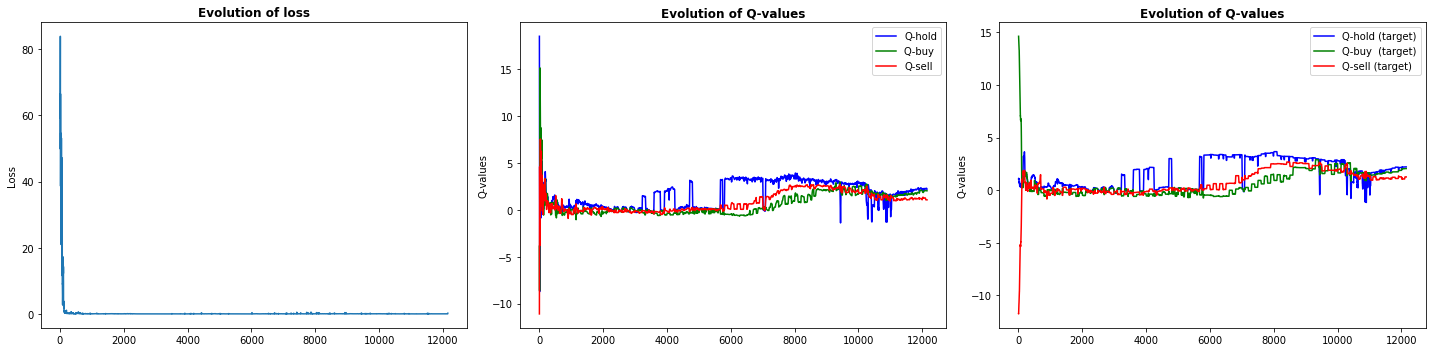

In [19]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [20]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    

# Compute mean
balances2 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances2.shape[0]))
print('Mean : {}'.format(balances2.mean()))
print('Std  : {}'.format(balances2.std()))

Count: 424
Mean : 0.3297024275194316
Std  : 1.004329700320816


### CAT

2020-09-03 22:57:14,143 : INFO Creating environment
2020-09-03 22:57:14,145 : INFO Start downloading data from CAT
2020-09-03 22:57:14,792 : INFO Build Dense DQN


Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-09-03 22:57:15,877 : INFO Creating agent
2020-09-03 22:57:19,833 : INFO Training DDQL
2020-09-03 22:57:19,838 : DEBUG Running episode 0/50
2020-09-03 22:59:40,738 : DEBUG Running episode 10/50
2020-09-03 23:02:16,562 : DEBUG Running episode 20/50
2020-09-03 23:05:00,913 : DEBUG Running episode 30/50
2020-09-03 23:07:59,991 : DEBUG Running episode 40/50


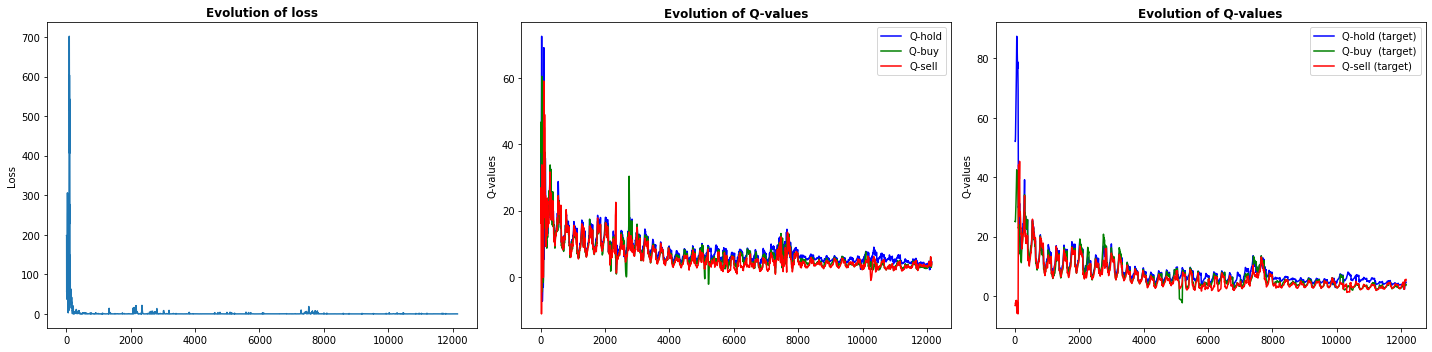

In [21]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [22]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    
# Compute mean
balances3 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances3.shape[0]))
print('Mean : {}'.format(balances3.mean()))
print('Std  : {}'.format(balances3.std()))

Count: 424
Mean : 1.2217526817646729
Std  : 1.0315087105148075


### Random

2020-09-04 00:14:07,895 : INFO Creating environment
2020-09-04 00:14:07,895 : INFO Start downloading data from S&P500
2020-09-04 00:15:09,232 : DEBUG Error downloading data from CARR
2020-09-04 00:16:26,145 : DEBUG Error downloading data from FCX
2020-09-04 00:16:27,066 : DEBUG Error downloading data from GPS
2020-09-04 00:16:29,826 : DEBUG Error downloading data from GD
2020-09-04 00:16:44,303 : DEBUG Error downloading data from HAS
2020-09-04 00:16:54,829 : DEBUG Error downloading data from HD
2020-09-04 00:16:56,058 : DEBUG Error downloading data from HON
2020-09-04 00:17:03,615 : DEBUG Error downloading data from HII
2020-09-04 00:17:13,362 : DEBUG Error downloading data from ICE
2020-09-04 00:17:14,353 : DEBUG Error downloading data from IBM
2020-09-04 00:17:19,108 : DEBUG Error downloading data from IFF
2020-09-04 00:17:21,521 : DEBUG Error downloading data from ISRG
2020-09-04 00:17:22,469 : DEBUG Error downloading data from IVZ
2020-09-04 00:17:23,301 : DEBUG Error downloading 

Model: "Dense_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Flatten_prices (Flatten)        (None, 32)           0           Prices[0][0]                     
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 32)           1056        Flatten_prices[0][0]             
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 32)           1056        Dense_1[0][0]                    
__________________________________________________________________________________________

2020-09-04 00:21:36,617 : INFO Creating agent
2020-09-04 00:21:42,242 : INFO Training DDQL
2020-09-04 00:21:42,247 : DEBUG Running episode 0/50
2020-09-04 00:25:04,932 : DEBUG Running episode 10/50
2020-09-04 00:28:46,272 : DEBUG Running episode 20/50
2020-09-04 00:32:35,664 : DEBUG Running episode 30/50
2020-09-04 00:36:59,716 : DEBUG Running episode 40/50


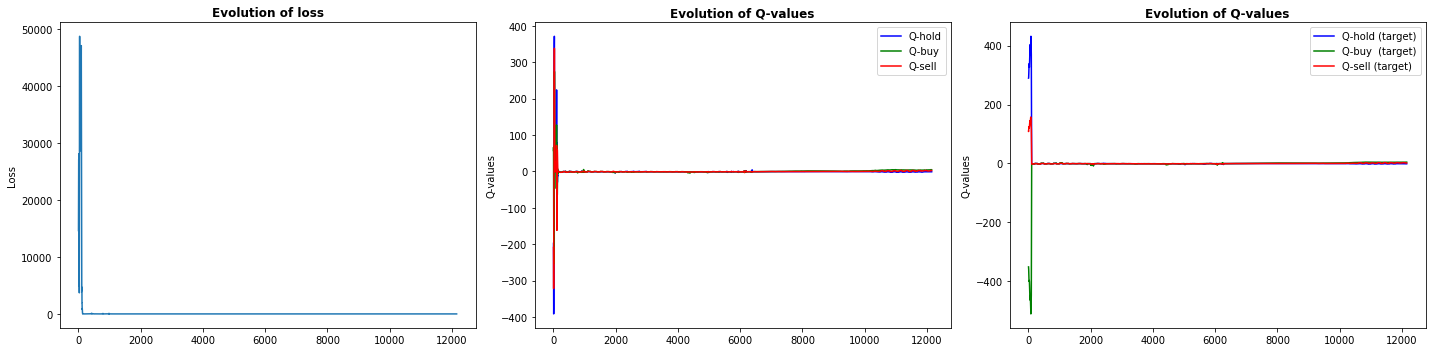

In [23]:
# Create environment
env = OneRandomStockEnv(date_start   = datetime(2015, 1, 1), 
                        date_end     = datetime(2019, 12, 31), 
                        time_horizon = 32, 
                        time_skip    = 5
                        )

# Create model
model = build_model_Dense(time_horizon = env.time_horizon, 
                          n_features   = env.n_features, 
                          n_actions    = env.n_actions,
                          hidden_size  = 32
                          )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [24]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    
# Compute mean
balances4 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances4.shape[0]))
print('Mean : {}'.format(balances4.mean()))
print('Std  : {}'.format(balances4.std()))

Count: 424
Mean : 1.6528078685169107
Std  : 1.017535306178141


## Recurrent Neural Network with random stock

### AAPL

2020-09-07 21:26:54,053 : INFO Creating environment
2020-09-07 21:26:54,055 : INFO Start downloading data from AAPL
2020-09-07 21:26:55,368 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-09-07 21:26:57,069 : INFO Creating agent
2020-09-07 21:26:58,254 : INFO Training DDQL
2020-09-07 21:26:58,258 : DEBUG Running episode 0/50
2020-09-07 21:32:33,492 : DEBUG Running episode 10/50
2020-09-07 21:38:56,755 : DEBUG Running episode 20/50
2020-09-07 21:46:58,101 : DEBUG Running episode 30/50
2020-09-07 21:56:54,266 : DEBUG Running episode 40/50


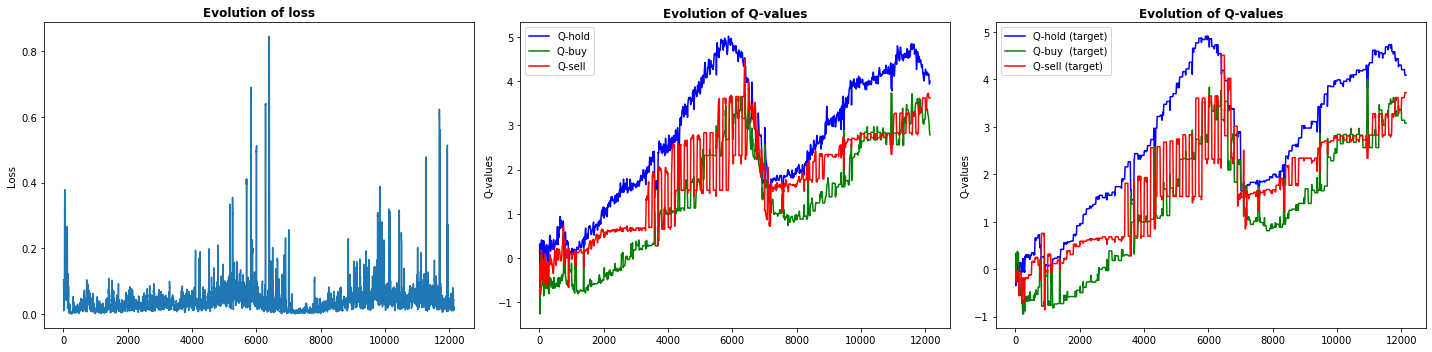

In [14]:
# Create environment
env = OneStockEnv(stock = 'AAPL',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [16]:
# Get available stocks
env_test = OneRandomStockEnv(date_start   = datetime(2015, 1, 1), 
                        date_end     = datetime(2019, 12, 31), 
                        time_horizon = 32, 
                        time_skip    = 5
                        )

stocks_list = env_test.data_raw.columns.tolist()
env_test.time_skip = 1

# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]

# Compute mean
balances1 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances5.shape[0]))
print('Mean : {}'.format(np.nanmean(balances5)))
print('Std  : {}'.format(np.nanstd(balances5)))

2020-09-07 22:12:20,000 : INFO Creating environment
2020-09-07 22:12:20,321 : INFO Start downloading data from S&P500
2020-09-07 22:14:12,772 : DEBUG Error downloading data from CARR
2020-09-07 22:17:58,859 : DEBUG Error downloading data from ICE
2020-09-07 22:18:00,356 : DEBUG Error downloading data from IBM
2020-09-07 22:18:05,053 : DEBUG Error downloading data from IFF
2020-09-07 22:18:09,041 : DEBUG Error downloading data from ISRG
2020-09-07 22:18:10,713 : DEBUG Error downloading data from IVZ
2020-09-07 22:18:12,353 : DEBUG Error downloading data from IPGP
2020-09-07 22:18:16,642 : DEBUG Error downloading data from JKHY
2020-09-07 22:18:20,315 : DEBUG Error downloading data from JBHT
2020-09-07 22:18:35,597 : DEBUG Error downloading data from KSU
2020-09-07 22:18:37,061 : DEBUG Error downloading data from K
2020-09-07 22:18:39,587 : DEBUG Error downloading data from KEYS
2020-09-07 22:18:44,773 : DEBUG Error downloading data from KMI
2020-09-07 22:18:52,002 : DEBUG Error download

Count: 437
Mean : 1.6534840927591796
Std  : 1.0039953567714672


### GE

2020-09-08 00:36:24,848 : INFO Creating environment
2020-09-08 00:36:25,183 : INFO Start downloading data from GE
2020-09-08 00:36:26,506 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-09-08 00:36:28,205 : INFO Creating agent
2020-09-08 00:36:45,517 : INFO Training DDQL
2020-09-08 00:36:45,524 : DEBUG Running episode 0/50
2020-09-08 00:49:23,927 : DEBUG Running episode 10/50
2020-09-08 01:02:46,108 : DEBUG Running episode 20/50
2020-09-08 01:18:04,681 : DEBUG Running episode 30/50
2020-09-08 01:34:28,526 : DEBUG Running episode 40/50


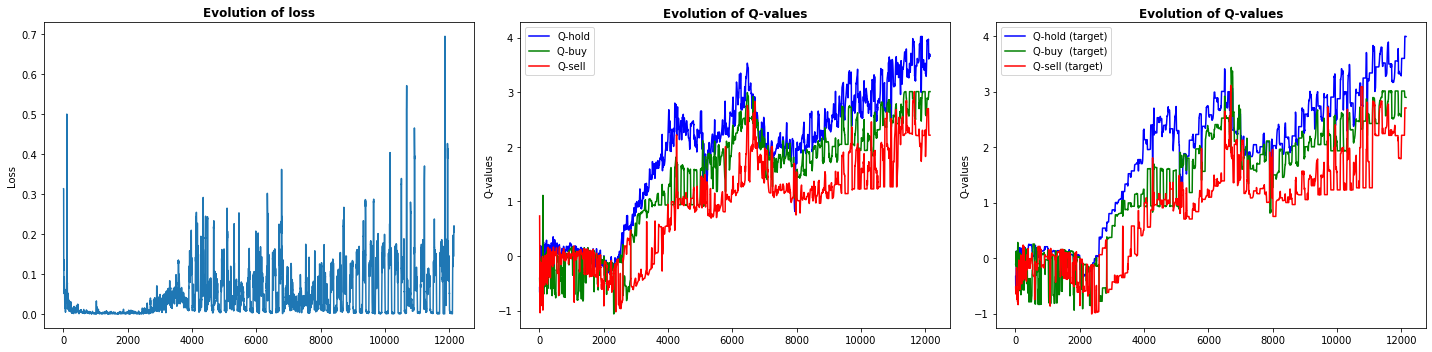

In [17]:
# Create environment
env = OneStockEnv(stock = 'GE',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [18]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    
# Compute mean
balances6 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances6.shape[0]))
print('Mean : {}'.format(np.nanmean(balances6)))
print('Std  : {}'.format(np.nanstd(balances6)))

Count: 437
Mean : 0.32651590724082036
Std  : 1.0039953567714672


### CAT

2020-09-08 03:50:13,600 : INFO Creating environment
2020-09-08 03:50:13,669 : INFO Start downloading data from CAT
2020-09-08 03:50:15,015 : INFO Build LSTM DQN


Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-09-08 03:50:16,709 : INFO Creating agent
2020-09-08 03:50:48,389 : INFO Training DDQL
2020-09-08 03:50:48,394 : DEBUG Running episode 0/50
2020-09-08 04:08:40,592 : DEBUG Running episode 10/50
2020-09-08 04:28:06,696 : DEBUG Running episode 20/50
2020-09-08 04:48:30,364 : DEBUG Running episode 30/50
2020-09-08 05:12:44,909 : DEBUG Running episode 40/50


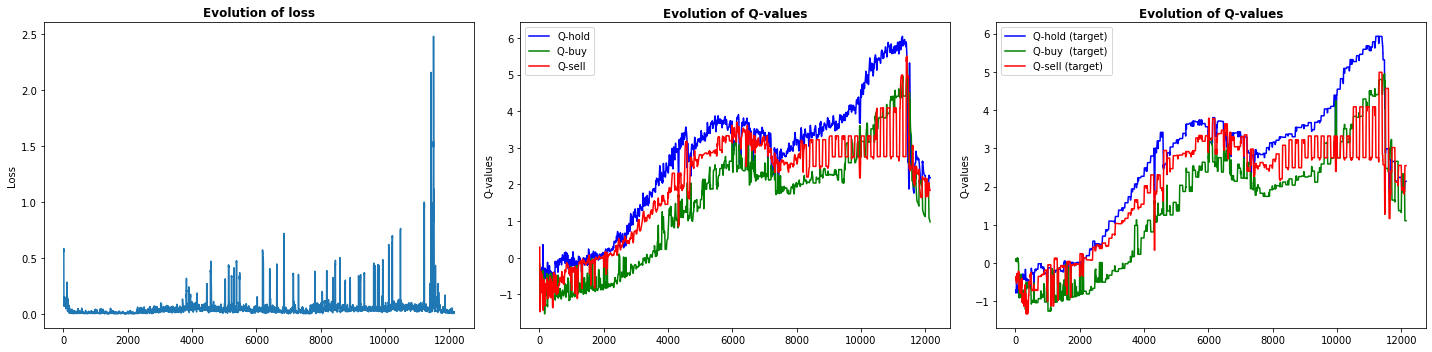

In [19]:
# Create environment
env = OneStockEnv(stock = 'CAT',
                  date_start   = datetime(2015, 1, 1), 
                  date_end     = datetime(2019, 12, 31), 
                  time_horizon = 32, 
                  time_skip    = 5,
                  fee = 0.01
                  )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [20]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    
# Compute mean
balances7 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances7.shape[0]))
print('Mean : {}'.format(np.nanmean(balances7)))
print('Std  : {}'.format(np.nanstd(balances7)))

Count: 437
Mean : 1.6534840927591796
Std  : 1.0039953567714672


### Random

2020-09-08 09:06:34,007 : INFO Creating environment
2020-09-08 09:06:34,320 : INFO Start downloading data from S&P500
2020-09-08 09:08:19,470 : DEBUG Error downloading data from CARR
2020-09-08 09:11:05,687 : DEBUG Error downloading data from HD
2020-09-08 09:11:07,011 : DEBUG Error downloading data from HON
2020-09-08 09:11:17,449 : DEBUG Error downloading data from HII
2020-09-08 09:11:30,428 : DEBUG Error downloading data from ICE
2020-09-08 09:11:31,584 : DEBUG Error downloading data from IBM
2020-09-08 09:11:35,854 : DEBUG Error downloading data from IFF
2020-09-08 09:11:38,718 : DEBUG Error downloading data from ISRG
2020-09-08 09:11:55,641 : DEBUG Error downloading data from KEYS
2020-09-08 09:12:00,735 : DEBUG Error downloading data from KMI
2020-09-08 09:12:06,793 : DEBUG Error downloading data from KR
2020-09-08 09:12:09,469 : DEBUG Error downloading data from LHX
2020-09-08 09:12:28,342 : DEBUG Error downloading data from LKQ
2020-09-08 09:12:43,723 : DEBUG Error downloading

Model: "LSTM_DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Prices (InputLayer)             [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
Bidirectional_LSTM (Bidirection (None, 32, 64)       8704        Prices[0][0]                     
__________________________________________________________________________________________________
Position (InputLayer)           [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
LSTM_2 (LSTM)                   (None, 32)           12416       Bidirectional_LSTM[0][0]         
___________________________________________________________________________________________

2020-09-08 09:17:40,303 : INFO Creating agent
2020-09-08 09:18:55,869 : INFO Training DDQL
2020-09-08 09:18:55,886 : DEBUG Running episode 0/50
2020-09-08 09:57:34,095 : DEBUG Running episode 10/50
2020-09-08 10:45:13,565 : DEBUG Running episode 20/50
2020-09-08 11:26:08,497 : DEBUG Running episode 30/50
2020-09-08 12:02:27,683 : DEBUG Running episode 40/50


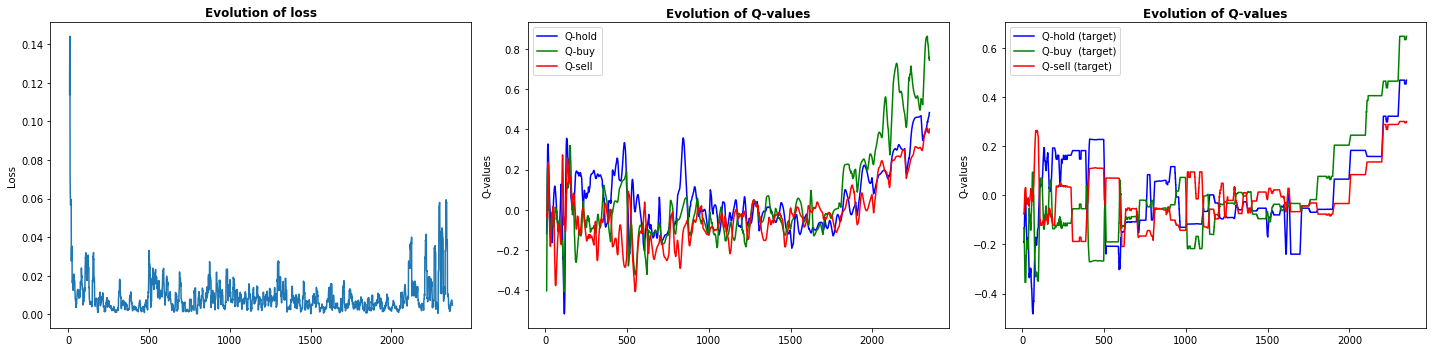

In [23]:
# Create environment
env = OneRandomStockEnv(date_start   = datetime(2015, 1, 1), 
                        date_end     = datetime(2019, 12, 31), 
                        time_horizon = 32, 
                        time_skip    = 5
                        )

# Create model
model = build_model_LSTM(time_horizon = env.time_horizon, 
                         n_features   = env.n_features, 
                         n_actions    = env.n_actions,
                         hidden_size  = env.time_horizon
                         )

# Create and train the agent
agent = AgentDQN(env, model)
agent.train_double_deep_q_learning(num_episodes = 50)

# Plot training stats
plot_training_stats(env, agent)
plt.show()

In [ ]:
# Loop over the stocks
balance = {}
for x in stocks_list:    
    # Run the episode
    state = env_test.reset(stock_new = x)
    done = False
    while done == False:
        # Obtain Q-values
        probs = agent.q_network.predict(state)
        action = np.argmax(probs)
        
        # Execute action
        state, reward, done, info = env_test.step(action)
        
    # Save balance
    balance[x] = env_test.df_stats['Balance'].iloc[-1]
    print(x,balance[x])
    
# Compute mean
balances8 = np.array([balance[x] for x in balance])
print('Count: {}'.format(balances8.shape[0]))
print('Mean : {}'.format(np.nanmean(balances8)))
print('Std  : {}'.format(np.nanstd(balances8)))

# REFERENCES

[1] Volodymyr Mnih et al. Playing Atari with Deep Reinforcement Learning. 2013. arXiv:1312.5602 [cs.LG].  
[2] Volodymyr Mnih et al. Human-level control through deep reinforcement learning. In: Nature 518 (2015), pp. 529–533.doi:10.1038/nature14236.  
[3] Hado van Hasselt, Arthur Guez, and David Silver. Deep Reinforcement Learning with Double Q-learning. 2015. arXiv:1509.06461 [cs.LG].